In [3]:
import psycopg2
import pandas as pd
import numpy as np
import mariadb
import json
import os
import shutil
import subprocess
from pathlib import Path
import pyodbc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [64]:
water_df = pd.read_csv("output/water_analysis_cleaned.csv")

In [65]:
water_df.analysis_name.value_counts().to_csv("output/analysis_value_counts.csv")

In [66]:
water_df.analysis_name = [ str(i).strip() for i in water_df.analysis_name]

In [67]:
pd.DataFrame(water_df.unit_name.value_counts())

count
unit_name         
ppm         168582
mpn/100ml    40057
mS cm -1     19517
cfu/100 ml   11829
cfu/ml        8410
in 100ml      2796
H.U            760
cfu/100ml      170
.              128
100 ml         100
mg/l            32
mpn/ml          14
mS/cm           10
mpn/g            8

In [68]:
water_df['analysis_name'] = [i.replace(":","") for i in water_df['analysis_name']]
water_df['result'] = [ float(str(i).replace("<","").replace(">","")) for i in water_df['result'] ]

In [69]:
water_df.sort_values("batch_date")

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
140096         30539         20585         22112       22112   
130958        153703        102969        110878      110878   
241214        153774        102996        110906      110906   
241639        153746        102989        110899      110899   
241425        153786        102999        110909      110909   
...              ...           ...           ...         ...   
42013        1526899       1075572       1148437     1148437   
74671        1544995       1089491       1163895     1163895   
122224       1543748       1088498       1162699     1162699   
63821        1543745       1088495       1162696     1162696   
31270        1543743       1088493       1162694     1162694   

              sample_code               batch_date  \
140096  CM003WA0024        2010-08-25 00:00:00.000   
130958  CS084WA0008        2010-10-11 00:00:00.000   
241214  CS084WA0009        2010-10-11 00:00:00.000   
241639  CS084WA0009        2010-10-11 00:00:00.000   
241425  CS084WA0009        2010-10-11 00:00:00.000   
...                   ...                      ...   
42013         CN419WA0001  2024-10-16 18:38:16.000   
74671         CN419WA0001  2024-10-16 18:38:16.000   
122224        CN419WA0001  2024-10-16 18:38:16.000   
63821         CN419WA0001  2024-10-16 18:38:16.000   
31270         CN419WA0001  2024-10-16 18:38:16.000   

                               analysis_name  chemical_name     result  \
140096     Feacal Coliforms (MPN) and E.Coli  feacal_e_coli     0.0000   
130958         Basic Drinking Water Analysis       ammonium     0.0100   
241214  Chemical & Biochemical Oxygen Demand        sulphur    24.5000   
241639  Chemical & Biochemical Oxygen Demand       ammonium     0.0100   
241425  Chemical & Biochemical Oxygen Demand      manganese     0.0056   
...                                      ...            ...        ...   
42013        Irrigation Water Analysis (FAO)       chloride  1550.0000   
74671        Irrigation Water Analysis (FAO)       hardness   555.0000   
122224       Irrigation Water Analysis (FAO)      nitrate_n     0.3000   
63821        Irrigation Water Analysis (FAO)      magnesium   129.0000   
31270        Irrigation Water Analysis (FAO)       ammonium     1.5700   

         unit_name  
140096  cfu/100 ml  
130958         ppm  
241214         ppm  
241639         ppm  
241425         ppm  
...            ...  
42013          ppm  
74671          ppm  
122224         ppm  
63821          ppm  
31270          ppm  

[252413 rows x 10 columns]

In [70]:
water_df = water_df.sort_values('sample_code')

In [71]:
water_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0     sample_code  \
150087        486813        326217        349319      349319  AGD105-3WA0001   
177073        486812        326217        349319      349319  AGD105-3WA0001   
147621        904383        611717        653466      653466  AGD105-3WA0001   
153847        486813        326217        349319      349319  AGD105-3WA0001   
159393        904383        611717        653466      653466  AGD105-3WA0001   
...              ...           ...           ...         ...             ...   
177625        857708        580836        620522      620522  I48-1-73WA0005   
178651        857701        580829        620515      620515  I48-1-73WA0006   
177624        857702        580830        620516      620516  I48-1-73WA0006   
221035        941039        637082        680371      680371  I48-1-77WA0003   
221015        936962        634046        677163      677163  I48-1-77WA0004   

                     batch_date                      analysis_name  \
150087  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
177073  2021-01-18 12:49:00.000           E coli & Total Coliforms   
147621  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
153847  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
159393  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
...                         ...                                ...   
177625  2018-05-02 00:00:00.000        Post Harvest Water Analysis   
178651  2018-05-02 00:00:00.000        Post Harvest Water Analysis   
177624  2018-05-02 00:00:00.000        Post Harvest Water Analysis   
221035  2018-08-29 00:00:00.000  Total Coliforms and Faecal E.Coli   
221015  2018-08-29 00:00:00.000  Total Coliforms and Faecal E.Coli   

                  chemical_name  result   unit_name  
150087  electrical_conductivity    1.08    mS cm -1  
177073  electrical_conductivity    1.08    mS cm -1  
147621   total_suspended_solids    1.00         ppm  
153847  electrical_conductivity    1.08    mS cm -1  
159393   total_suspended_solids    1.00         ppm  
...                         ...     ...         ...  
177625        tbc_at_22_degrees  670.00      cfu/ml  
178651        tbc_at_37_degrees   92.00      cfu/ml  
177624        tbc_at_22_degrees  120.00      cfu/ml  
221035            faecal_e_coli    3.00  cfu/100 ml  
221015            faecal_e_coli    1.00  cfu/100 ml  

[252413 rows x 10 columns]

In [72]:
new_samples_df = water_df.loc[water_df['batch_date'] > '2024-05-21'] 
water_df = water_df.loc[water_df['batch_date'] <= '2024-05-21'] 

In [73]:
new_samples_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0   sample_code  \
160536       1590964       1120681       1200160     1200160  AGD517WA0013   
156698       1590912       1120638       1200107     1200107  AGD517WA0013   
152938       1590912       1120638       1200107     1200107  AGD517WA0013   
148764       1590964       1120681       1200160     1200160  AGD517WA0013   
152939       1590973       1120690       1200170     1200170  AGD517WA0014   
...              ...           ...           ...         ...           ...   
148734       1563465       1100984       1177044     1177044   FA948WA0010   
152907       1562709       1100635       1176673     1176673   FA948WA0010   
13319        1615597       1137008       1218988     1218988   FA951WA0001   
7275         1615598       1137009       1218989     1218989   FA951WA0001   
20376        1614984       1136638       1218585     1218585   FA951WA0001   

                     batch_date                           analysis_name  \
160536  2024-05-23 11:24:00.000               Reverse Osmosis Water Use   
156698  2024-05-23 11:24:00.000               Reverse Osmosis Water Use   
152938  2024-05-23 11:24:00.000               Reverse Osmosis Water Use   
148764  2024-05-23 11:24:00.000               Reverse Osmosis Water Use   
152939  2024-05-23 11:24:00.000               Reverse Osmosis Water Use   
...                         ...                                     ...   
148734  2024-10-03 15:25:00.000               Reverse Osmosis Water Use   
152907  2024-10-03 15:25:00.000               Reverse Osmosis Water Use   
13319   2024-07-25 08:42:00.000  Standard Drinking Water Analysis (WHO)   
7275    2024-07-25 08:42:00.000  Standard Drinking Water Analysis (WHO)   
20376   2024-07-25 08:42:00.000  Standard Drinking Water Analysis (WHO)   

                  chemical_name  result  unit_name  
160536   total_suspended_solids    0.00        ppm  
156698  electrical_conductivity    1.56   mS cm -1  
152938  electrical_conductivity    1.56   mS cm -1  
148764   total_suspended_solids    0.00        ppm  
152939  electrical_conductivity    0.47   mS cm -1  
...                         ...     ...        ...  
148734   total_suspended_solids   16.00        ppm  
152907  electrical_conductivity    1.15   mS cm -1  
13319                    e_coli    0.00  mpn/100ml  
7275            total_coliforms    5.00  mpn/100ml  
20376   electrical_conductivity    0.16   mS cm -1  

[17496 rows x 10 columns]

In [74]:
water_df.analysis_name.value_counts().to_csv("output/modelling_analysis_value_counts.csv")
new_samples_df.analysis_name.value_counts().to_csv("output/test_analysis_value_counts.csv")

In [75]:
water_df['analysis_name'].nunique()

89

In [76]:
new_samples_df['analysis_name'].nunique()

40

In [77]:
new_samples_df[(new_samples_df['analysis_name'].isin(water_df['analysis_name'].unique()))].analysis_name.nunique()

40

In [78]:
water_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0     sample_code  \
150087        486813        326217        349319      349319  AGD105-3WA0001   
177073        486812        326217        349319      349319  AGD105-3WA0001   
147621        904383        611717        653466      653466  AGD105-3WA0001   
153847        486813        326217        349319      349319  AGD105-3WA0001   
159393        904383        611717        653466      653466  AGD105-3WA0001   
...              ...           ...           ...         ...             ...   
177625        857708        580836        620522      620522  I48-1-73WA0005   
178651        857701        580829        620515      620515  I48-1-73WA0006   
177624        857702        580830        620516      620516  I48-1-73WA0006   
221035        941039        637082        680371      680371  I48-1-77WA0003   
221015        936962        634046        677163      677163  I48-1-77WA0004   

                     batch_date                      analysis_name  \
150087  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
177073  2021-01-18 12:49:00.000           E coli & Total Coliforms   
147621  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
153847  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
159393  2021-01-18 12:49:00.000          Reverse Osmosis Water Use   
...                         ...                                ...   
177625  2018-05-02 00:00:00.000        Post Harvest Water Analysis   
178651  2018-05-02 00:00:00.000        Post Harvest Water Analysis   
177624  2018-05-02 00:00:00.000        Post Harvest Water Analysis   
221035  2018-08-29 00:00:00.000  Total Coliforms and Faecal E.Coli   
221015  2018-08-29 00:00:00.000  Total Coliforms and Faecal E.Coli   

                  chemical_name  result   unit_name  
150087  electrical_conductivity    1.08    mS cm -1  
177073  electrical_conductivity    1.08    mS cm -1  
147621   total_suspended_solids    1.00         ppm  
153847  electrical_conductivity    1.08    mS cm -1  
159393   total_suspended_solids    1.00         ppm  
...                         ...     ...         ...  
177625        tbc_at_22_degrees  670.00      cfu/ml  
178651        tbc_at_37_degrees   92.00      cfu/ml  
177624        tbc_at_22_degrees  120.00      cfu/ml  
221035            faecal_e_coli    3.00  cfu/100 ml  
221015            faecal_e_coli    1.00  cfu/100 ml  

[234917 rows x 10 columns]

In [79]:
water_df.result.info()

<class 'pandas.core.series.Series'>
Index: 234917 entries, 150087 to 221015
Series name: result
Non-Null Count   Dtype  
--------------   -----  
234917 non-null  float64
dtypes: float64(1)
memory usage: 3.6 MB


In [80]:
water_df.sort_values("result")

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0     sample_code  \
213040       1158739        795198        848932      848932  AGD105-6WA0002   
2585         1083489        737056        786773      786773     CK059WA0554   
8626         1083488        737055        786772      786772     CK059WA0554   
2613         1086305        738930        788845      788845     CK059WA0546   
2608         1085742        738391        788264      788264     CK059WA0547   
...              ...           ...           ...         ...             ...   
250023        906823        613474        655388      655388     CI016WA0016   
250024        906893        613522        655439      655439     CI016WA0017   
250018        613977        415959        444599      444599     CI016WA0012   
250022        906790        613463        655377      655377     CI016WA0015   
250021        906548        613328        655234      655234     CI016WA0014   

                     batch_date                           analysis_name  \
213040  2021-05-04 10:36:00.000        KEBS Drinking Water Microbiology   
2585    2023-01-23 12:39:00.000  Standard Drinking Water Analysis (WHO)   
8626    2023-01-23 12:39:00.000  Standard Drinking Water Analysis (WHO)   
2613    2022-12-21 11:56:00.000  Standard Drinking Water Analysis (WHO)   
2608    2022-12-21 11:56:00.000  Standard Drinking Water Analysis (WHO)   
...                         ...                                     ...   
250023  2019-09-19 14:23:54.000                       Listeria Analysis   
250024  2019-09-19 14:23:54.000                       Listeria Analysis   
250018  2019-09-19 14:23:54.000                       Listeria Analysis   
250022  2019-09-19 14:23:54.000                       Listeria Analysis   
250021  2019-09-19 14:23:54.000                       Listeria Analysis   

          chemical_name     result  unit_name  
213040  total_coliforms        0.0  mpn/100ml  
2585    total_coliforms        0.0  mpn/100ml  
8626             e_coli        0.0  mpn/100ml  
2613    total_coliforms        0.0  mpn/100ml  
2608    total_coliforms        0.0  mpn/100ml  
...                 ...        ...        ...  
250023          tvc_@37  3000000.0     mpn/ml  
250024          tvc_@37  3000000.0     mpn/ml  
250018          tvc_@37  3000000.0     mpn/ml  
250022          tvc_@37  3000000.0     mpn/ml  
250021          tvc_@37  3000000.0     mpn/ml  

[234917 rows x 10 columns]

In [81]:
water_df['analysis_name'].value_counts()

analysis_name
Irrigation Water Analysis (FAO)           97092
Standard Drinking Water Analysis (WHO)    17959
Total Dissolved Solids                    17933
Reverse Osmosis Water Use                 15090
Water Colour Analysis                     10549
                                          ...  
TVC @22                                       2
Total Coliforms                               2
Most Probable Number                          2
Biochemical Oxygen Demand                     2
Faecal Streptococci                           1
Name: count, Length: 89, dtype: int64

In [82]:
for analysis in np.unique(water_df['analysis_name']):
    print(analysis)
    df_ = water_df.loc[water_df['analysis_name']==analysis]
    df_ = pd.pivot_table(data=df_, values="result", index="sample_code", columns="chemical_name")
    print(len(df_))

    os.makedirs(f"output/boxplots/{analysis}",exist_ok=True)
    for column in df_.columns:
        plt.boxplot(df_[column])
        plt.savefig(f"output/boxplots/{analysis}/{column}.png")
        plt.clf()
        outlier_threshold = df_[column].quantile(0.99)
        # df_ = df_.loc[df_[column] <= outlier_threshold]
    df_.describe().to_csv(f"output/chemical_null_count/{analysis}.csv")
    print(len(df_))
    
    df_.to_csv(f"output/analysis/{analysis}.csv")
    

Aerobic Mesophilic Count
5
5
Alkalinity in Water
238
238
Aluminium analysis
110
110
Aquasearch Full Chemical Analysis
34
34
Arsenic in Water
83
83
BT Extended Water Quality Analysis
13
13
Basic Drinking Water Analysis
3982
3982
Basic Drinking Water Analysis (WHO)
130
130
Biochemical Oxygen Demand
2
2
Biological Oxygen Demand
20
20
Carbonates in Water
47
47
Chemical & Biochemical Oxygen Demand
254
254
Chemical Oxygen Demand
27
27
Clostridium Perfringens
52
52
Colloidal Silica in Water
9
9
Dissolved(reactive) Silica
8
8
E coli
184
184
E coli & Total Coliforms
1745
1745
E.coli
19
19
Electrical Conductivity Analysis
8
8
Faecal Coliforms and Faecal E.Coli
77
77
Faecal E.Coli
15
15
Faecal Streptococci
1
1
Feacal Coliform (MPN) and E.Coli
172
172
Feacal Coliforms (MPN) and E.Coli
4523
4523
Fluoride in Water
181
181
Free Chlorine
801
801
Heavy Metal Analysis (Water)
488
488
Heavy Metal in Water
20
20
Heavy Metals in Water
2076
2076
Iron in Water
52
52
Irrigation Water Analysis
742
742
Irrigati

<Figure size 640x480 with 0 Axes>

In [48]:
print(len( os.listdir("output/analysis")))

88


In [ ]:
# for analysis_file in os.listdir("output/analysis"):
#     if f"{analysis_file.replace('.csv','')}.png" in os.listdir("./output/pairplots"):
#         continue
#     os.makedirs("./output/pairplots",exist_ok=True)
    
#     analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
#     print(analysis_file.replace('.csv',''))
#     sns.pairplot(analysis_df)
#     print('Saving')
#     plt.savefig(f"output/pairplots/{analysis_file.replace('.csv','')}.png")
#     print('Saved')
#     plt.clf()

Irrigation


In [118]:
os.makedirs("./output/analysis_imputed",exist_ok=True)
os.makedirs("./output/pca_plots",exist_ok=True)

Aerobic Mesophilic Count.csv
Number of components explaining 95% variance: 1
Alkalinity in Water.csv
Number of components explaining 95% variance: 3
Aluminium analysis.csv
Number of components explaining 95% variance: 13
Aquasearch Full Chemical Analysis.csv
Arsenic in Water.csv
Number of components explaining 95% variance: 2
Basic Drinking Water Analysis (WHO).csv
Number of components explaining 95% variance: 3
Basic Drinking Water Analysis.csv
Number of components explaining 95% variance: 8
Biochemical Oxygen Demand.csv
Biological Oxygen Demand.csv
BT Extended Water Quality Analysis.csv
Carbonates in Water.csv
Number of components explaining 95% variance: 7
Chemical & Biochemical Oxygen Demand.csv
Number of components explaining 95% variance: 12
Chemical Oxygen Demand.csv
Number of components explaining 95% variance: 2
Clostridium Perfringens.csv
Number of components explaining 95% variance: 4
Colloidal Silica in Water.csv
Number of components explaining 95% variance: 1
Dissolved(rea

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\600690271.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


Number of components explaining 95% variance: 3
Irrigation Water Analysis (FAO).csv
Number of components explaining 95% variance: 15
Irrigation Water Analysis.csv
Number of components explaining 95% variance: 6
KEBS Drinking Water Microbiology.csv
Number of components explaining 95% variance: 4
KEBS Drinking Water Min Monitoring Microbiology.csv
KEBS Drinking Water Minimum Monitoring.csv
KEBS Drinking Water Standard Analysis.csv
Number of components explaining 95% variance: 4
KS Drinking Water Standard Analysis.csv
Number of components explaining 95% variance: 2
KS Packaged Water Microbiology.csv
Number of components explaining 95% variance: 1
KS Potable Water Microbiology.csv
Legionella.csv


C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Number of components explaining 95% variance: 2
Listeria Analysis.csv
Number of components explaining 95% variance: 4
Listeria monocytogens.csv
Number of components explaining 95% variance: 1
Manganese in Water.csv
Number of components explaining 95% variance: 2
Most Probable Number.csv
Oil & Grease.csv
Number of components explaining 95% variance: 4
pH Analysis.csv
Number of components explaining 95% variance: 4
pH in Water.csv
Number of components explaining 95% variance: 3
Post Harvest Water Analysis.csv
Number of components explaining 95% variance: 2
Pseudomonas Aeruginosa.csv
Number of components explaining 95% variance: 4
Raw (Domestic) Water Analysis.csv
Reagent Water Analysis.csv
Reverse Osmosis Water Use.csv
Number of components explaining 95% variance: 13
Salmonella and E.Coli (Water).csv
Salmonella spp.csv
Number of components explaining 95% variance: 2
Salmonella.csv
Number of components explaining 95% variance: 1
Shigella spp.csv
Number of components explaining 95% varianc

C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Standard Drinking Water + Free Chlorine Analysis.csv
Standard Drinking Water Analysis (WHO).csv
Number of components explaining 95% variance: 4
Standard Drinking Water Analysis.csv
Number of components explaining 95% variance: 3
Standard Drinking Water.csv
Number of components explaining 95% variance: 1
Staphylococcus aureus.csv
Number of components explaining 95% variance: 3
Streptococcus faecalis.csv
Number of components explaining 95% variance: 4
Strontium Analysis.csv
Number of components explaining 95% variance: 3
Sulphite reducing anaerobes.csv
Number of components explaining 95% variance: 1
Sulphur in Water.csv
Number of components explaining 95% variance: 2
Total Bacteria Count.csv
Number of components explaining 95% variance: 6
Total Bacterial Count.csv
Number of components explaining 95% variance: 6
Total Chlorine.csv
Number of components explaining 95% variance: 3
Total Coliform and Faecal E.Coli.csv
Number of components explaining 95% variance: 4
Total Coliforms and Faecal 

C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Number of components explaining 95% variance: 1
Water Borne Diseases.csv
Number of components explaining 95% variance: 9
Water Colour Analysis.csv
Number of components explaining 95% variance: 22
Water Hardness Analysis.csv
Water Microbiology (KEBS).csv
Yeast & Mould.csv
Number of components explaining 95% variance: 2
Yeasts & Molds.csv
Number of components explaining 95% variance: 4


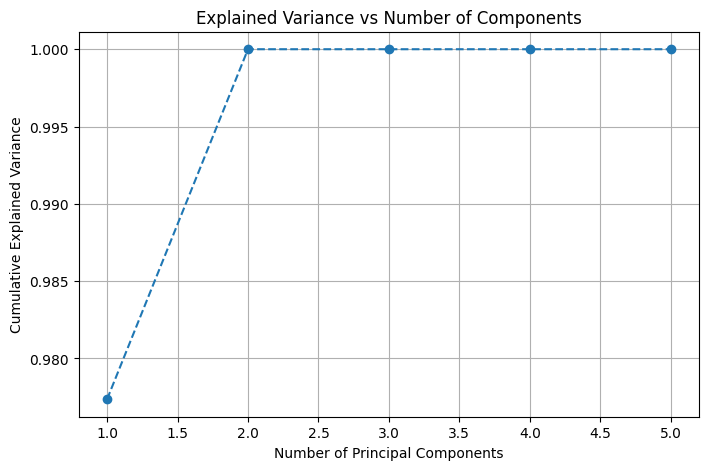

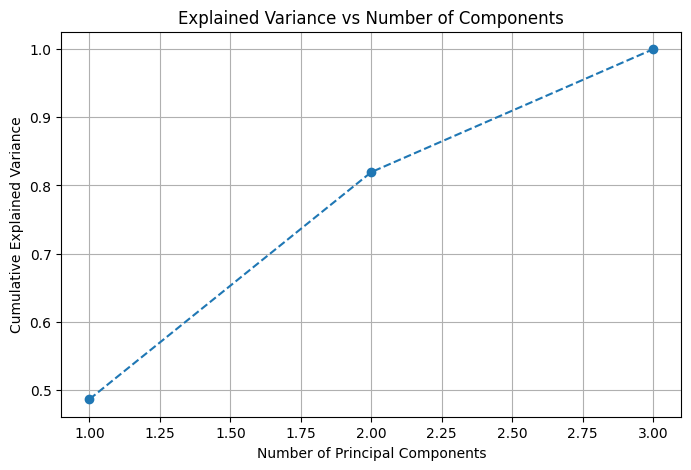

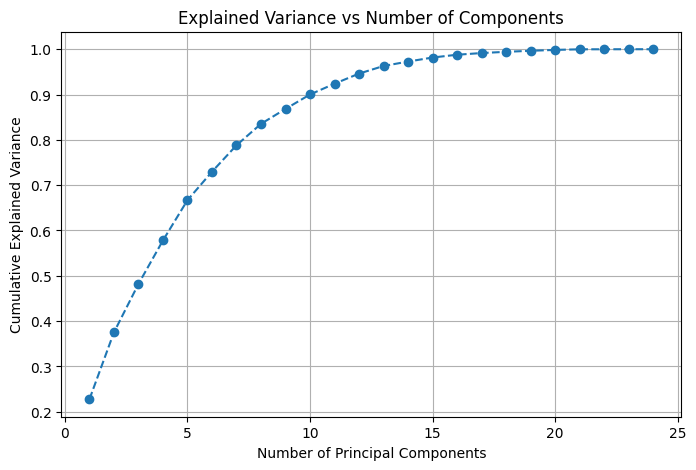

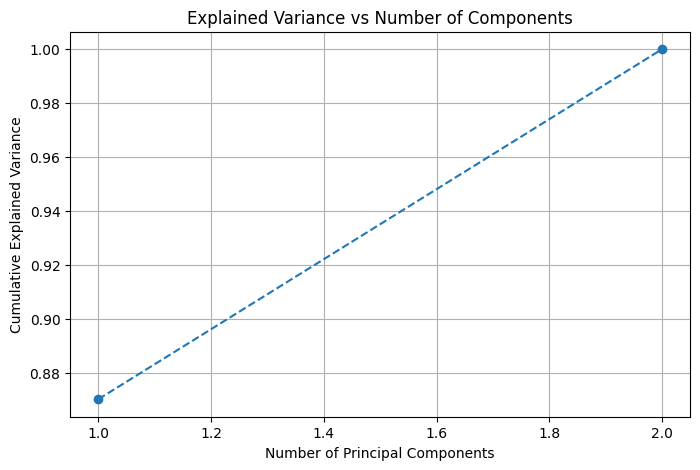

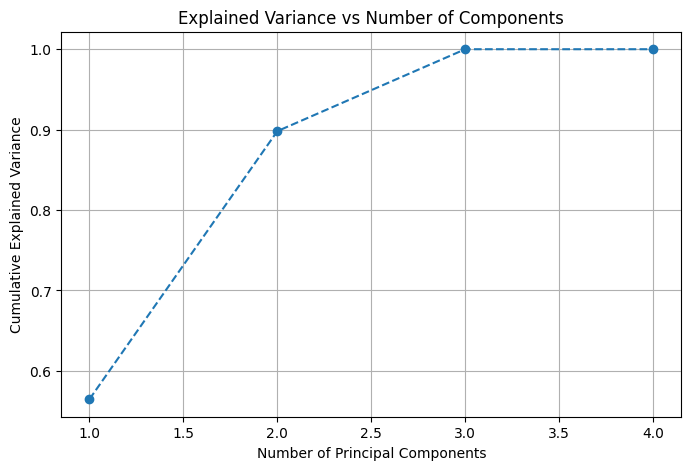

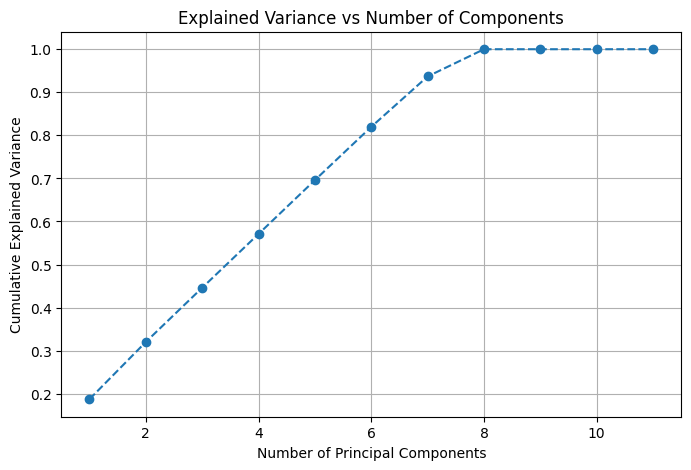

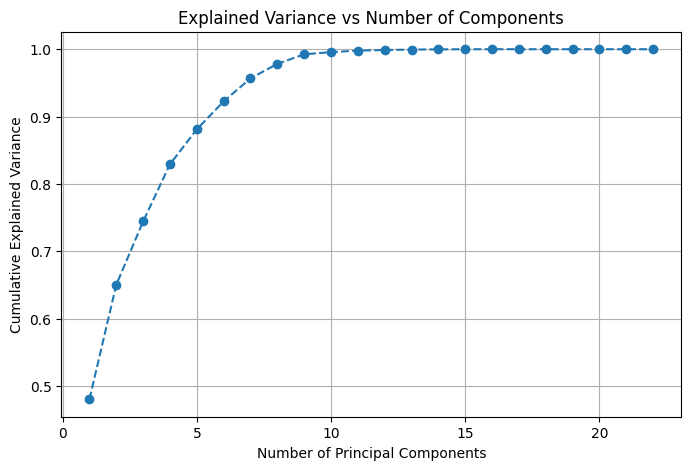

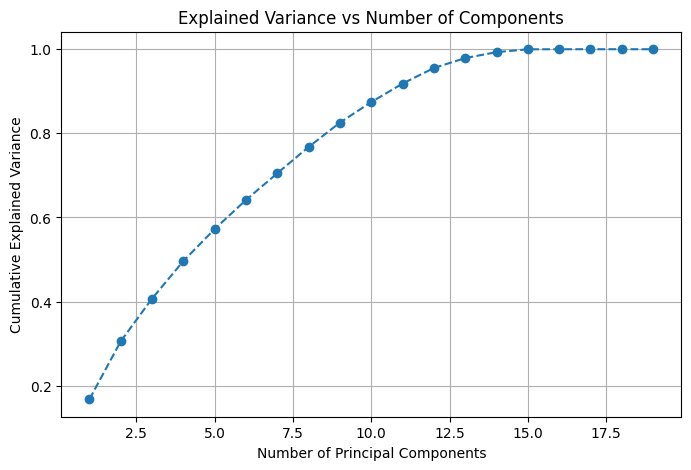

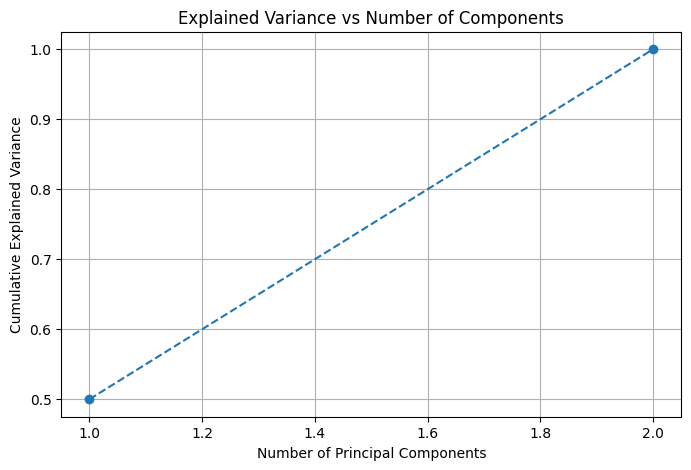

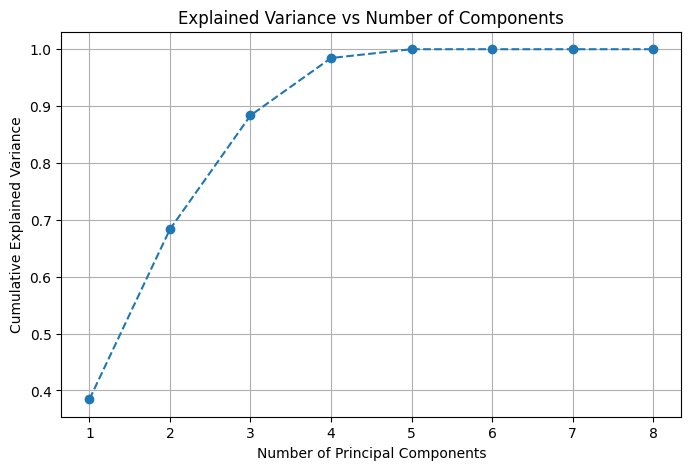

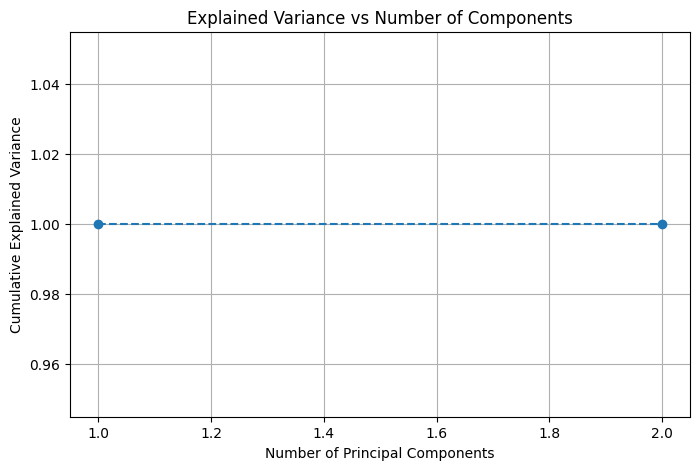

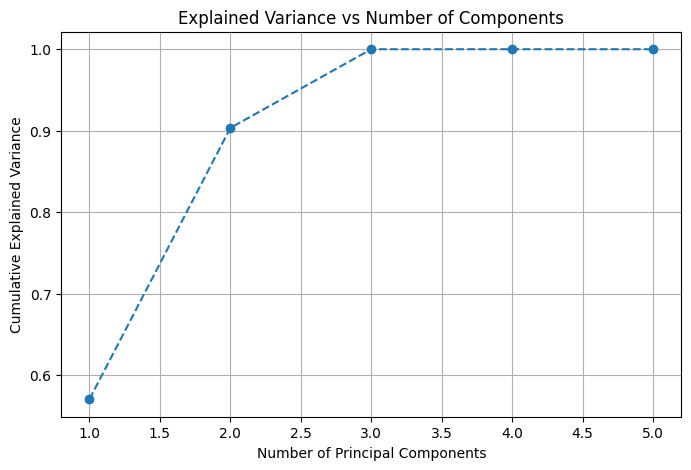

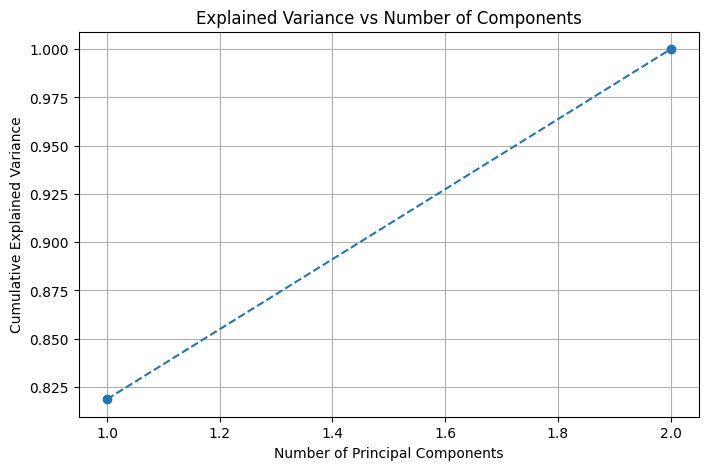

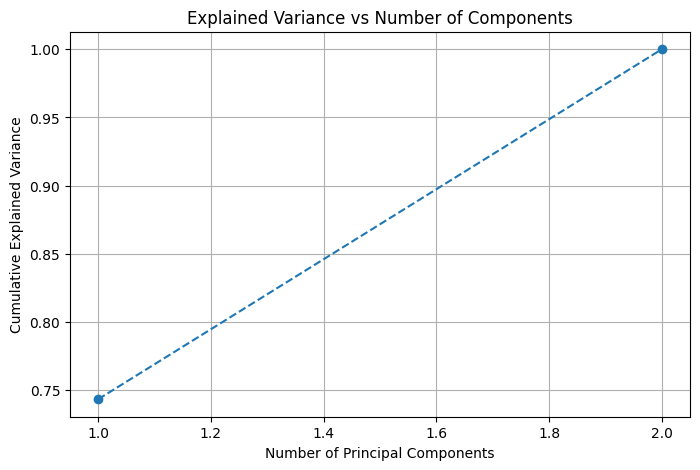

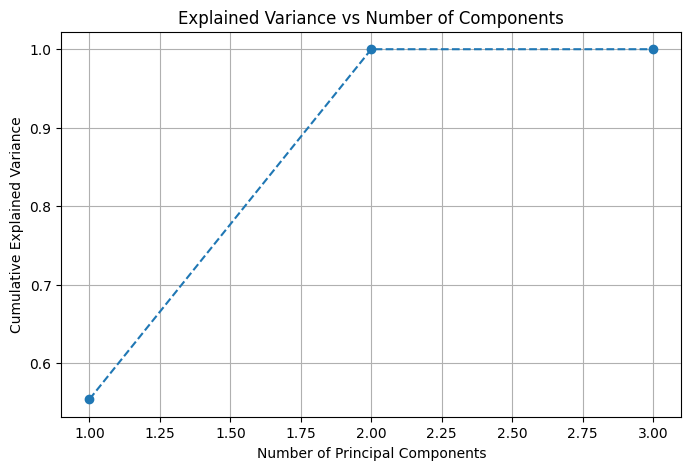

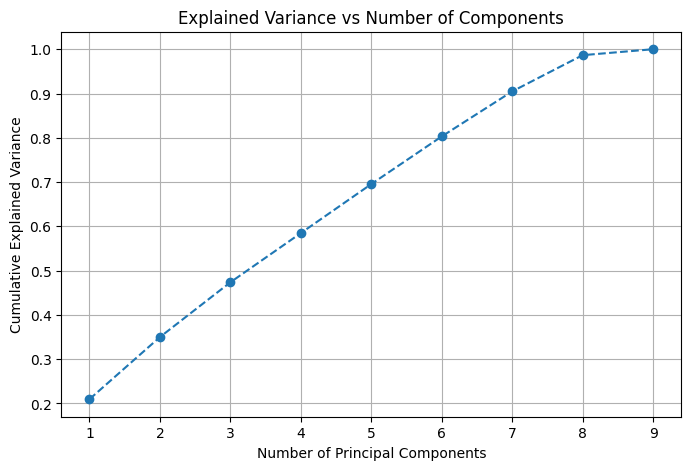

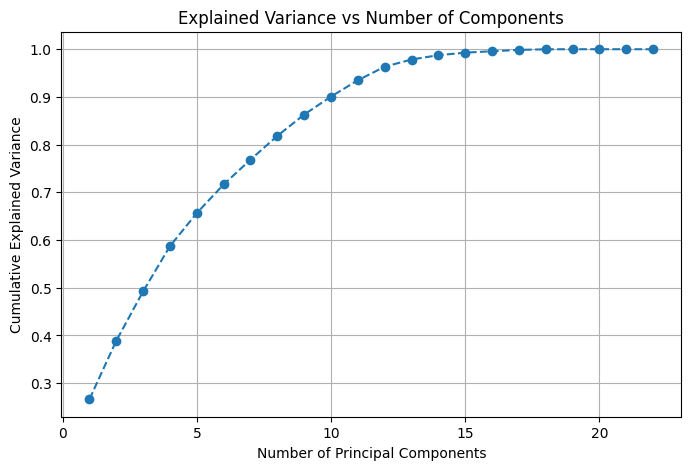

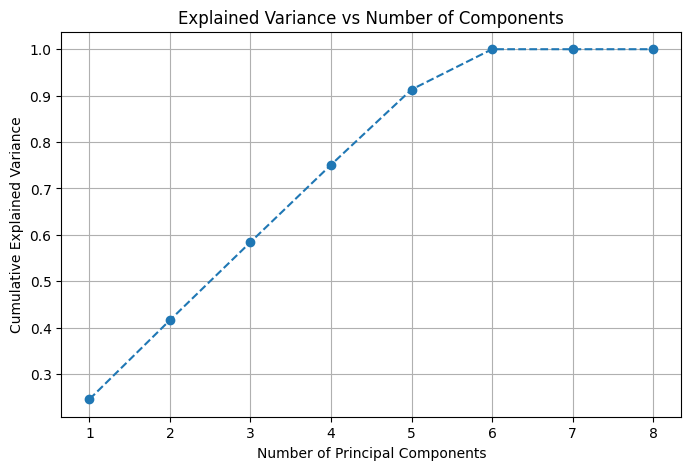

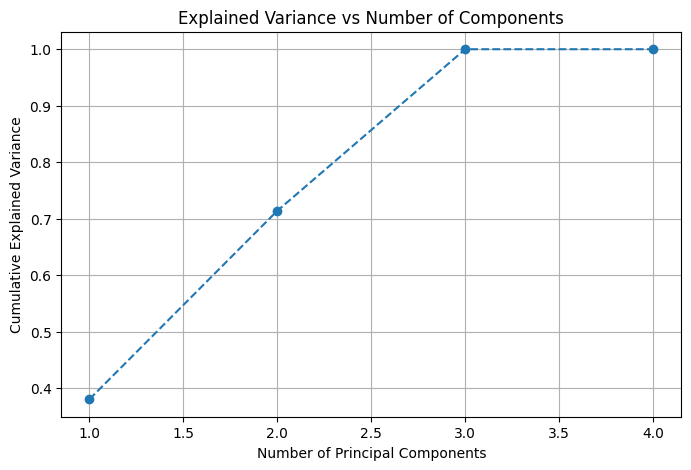

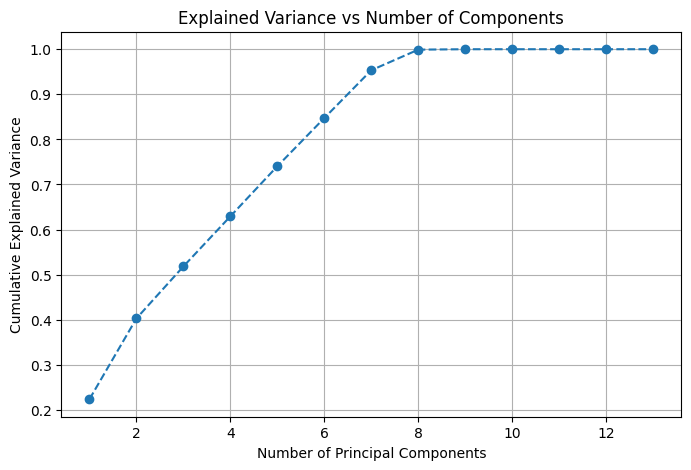

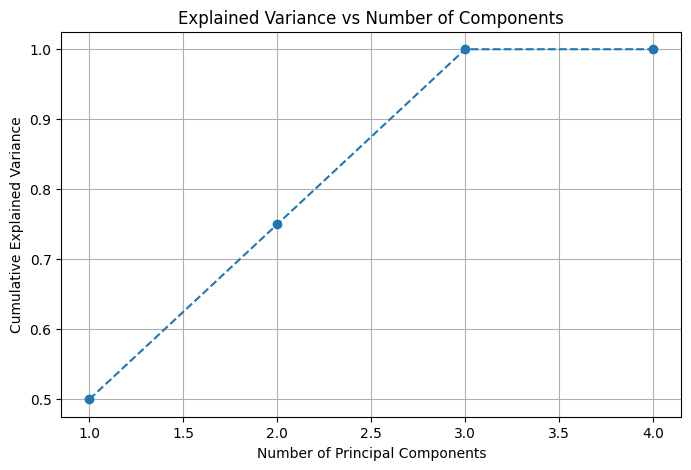

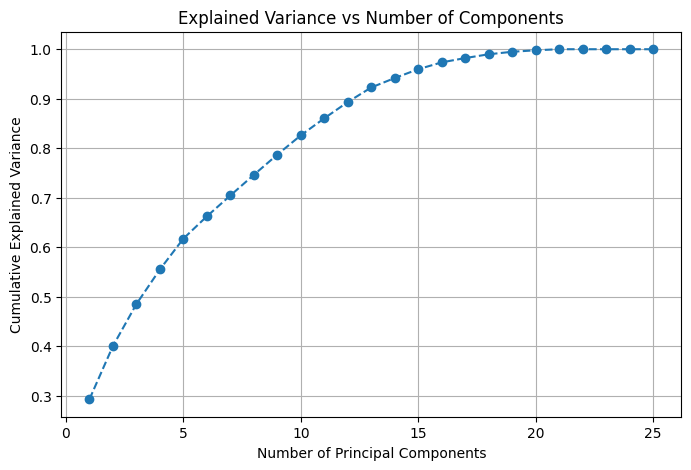

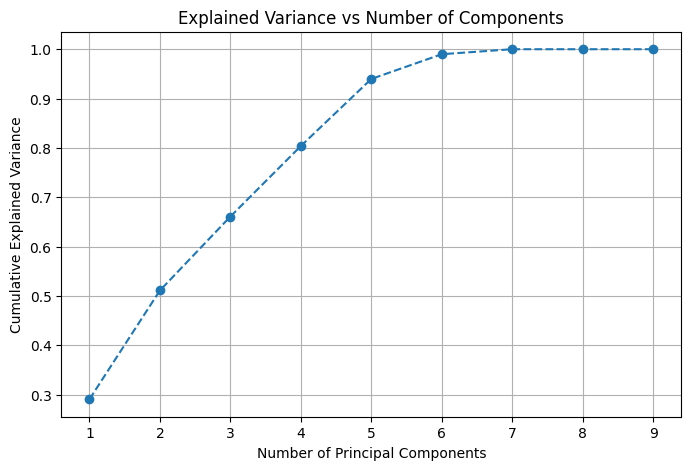

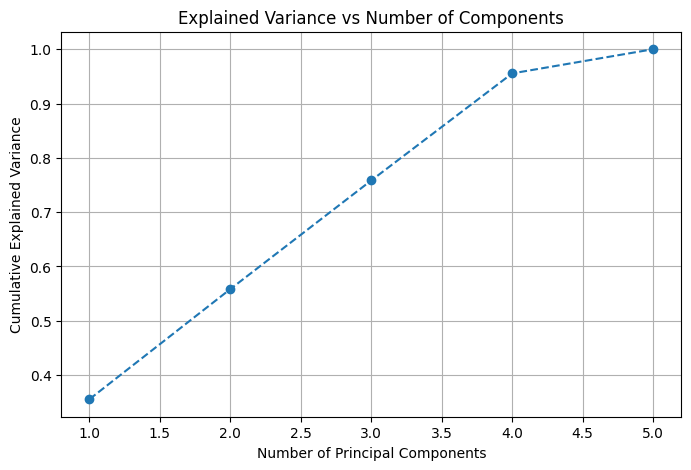

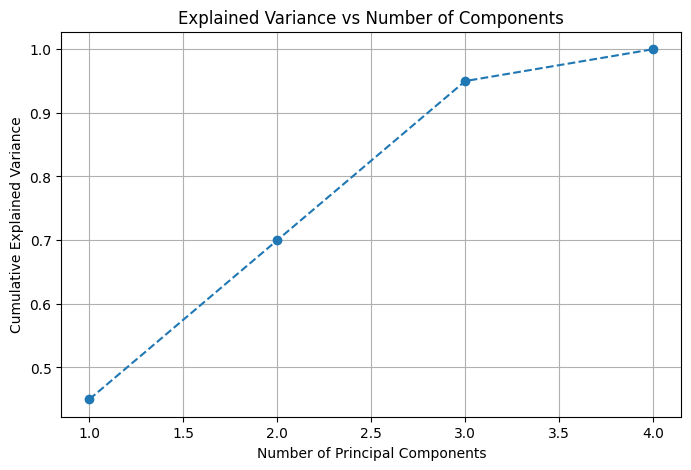

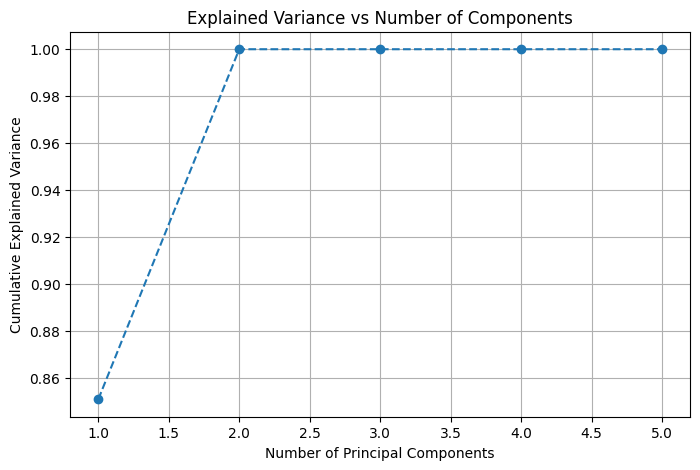

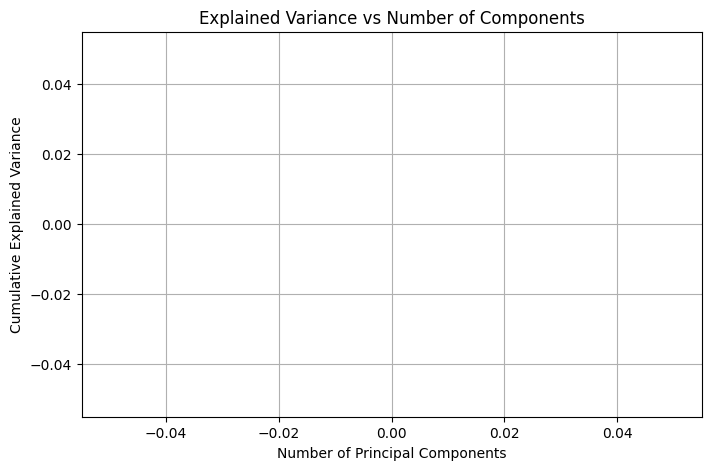

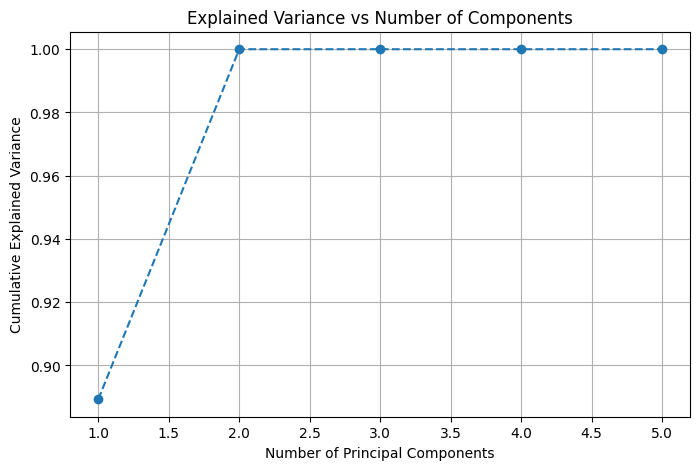

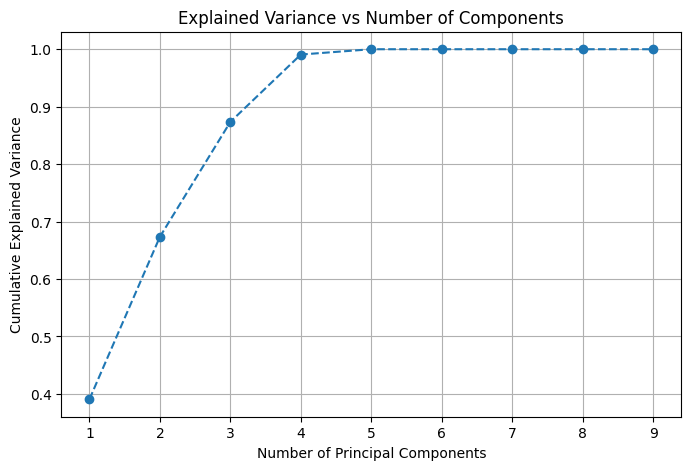

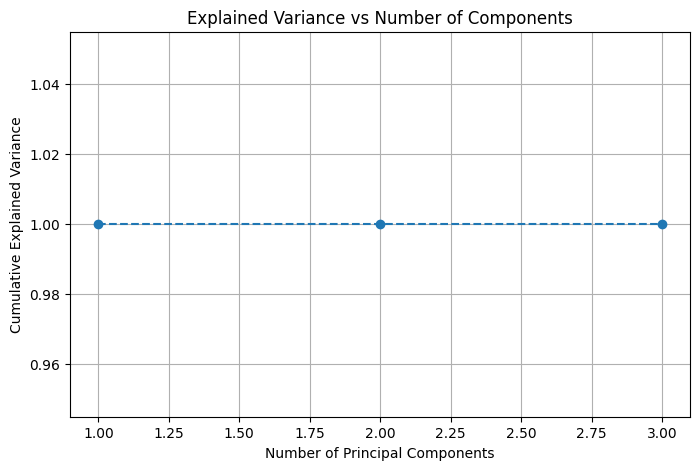

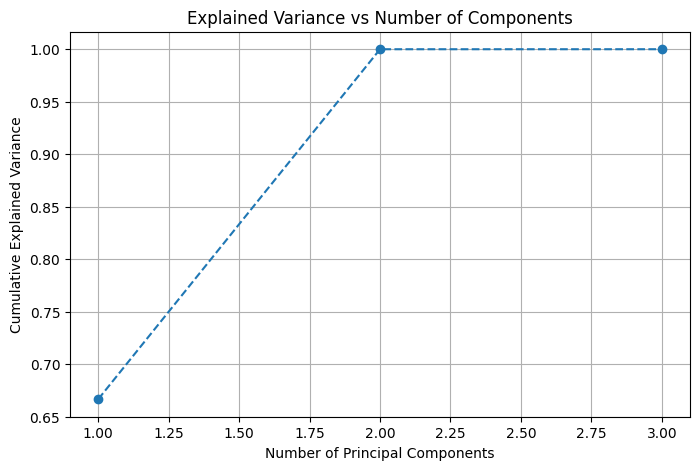

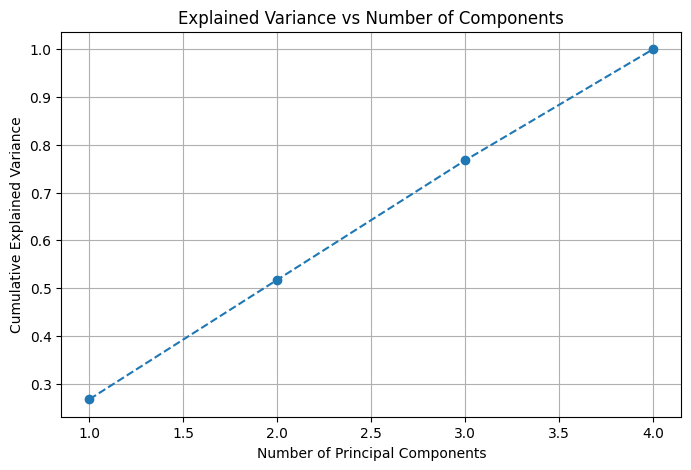

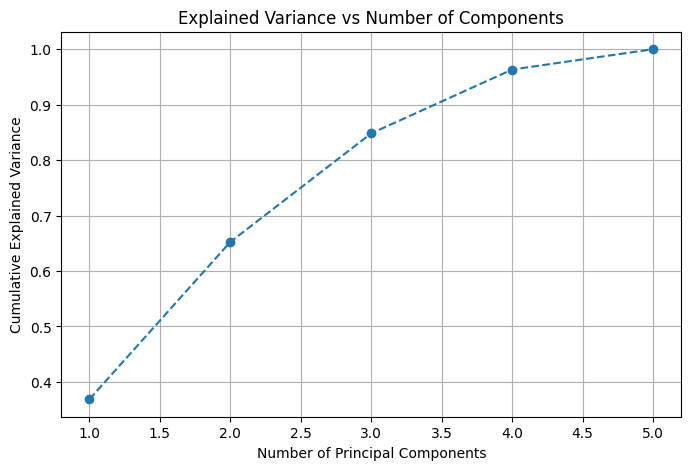

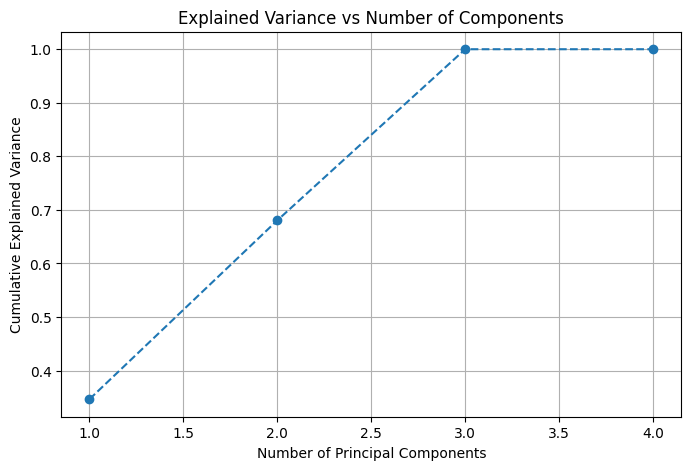

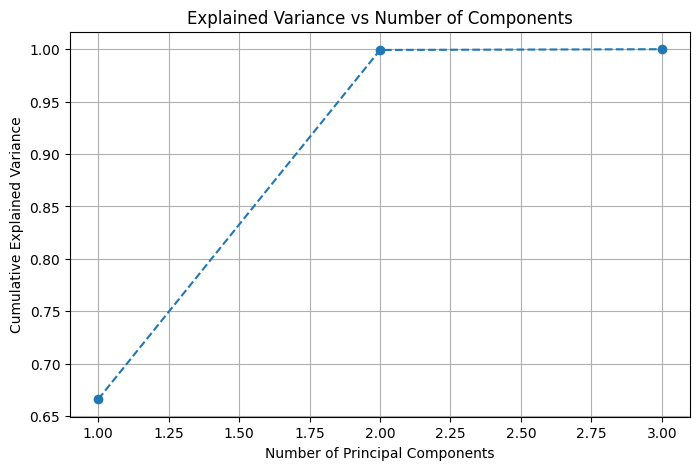

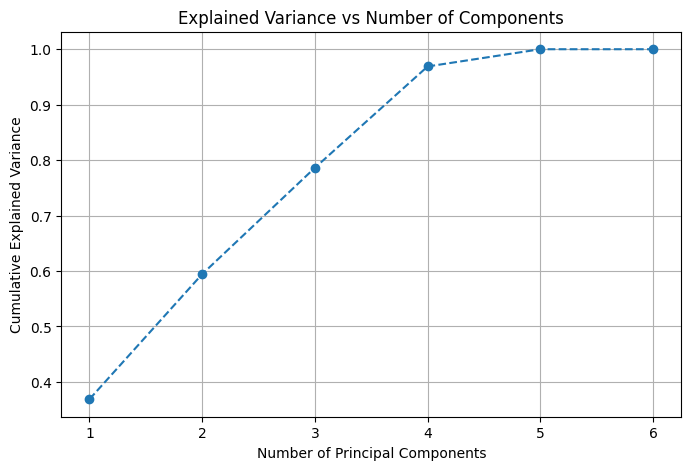

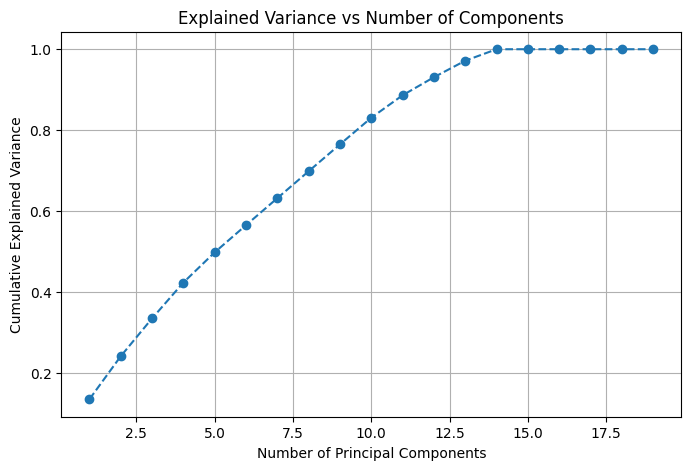

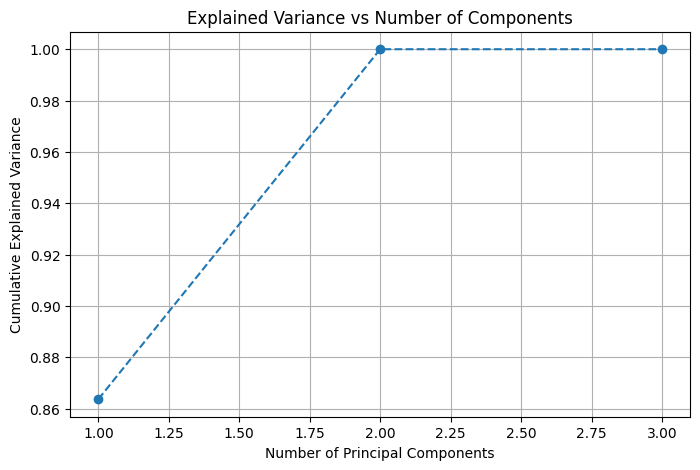

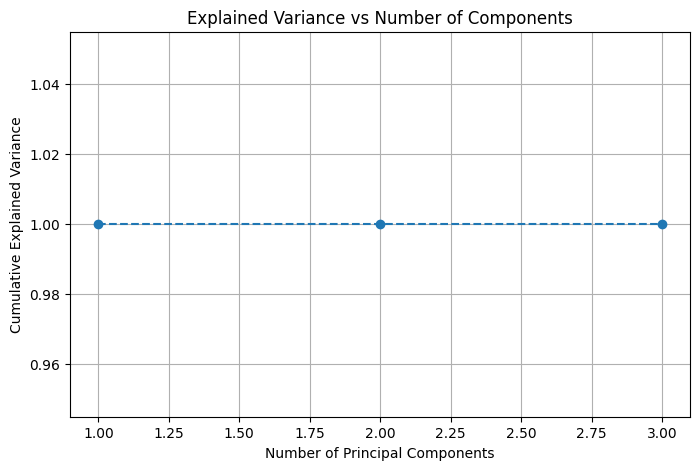

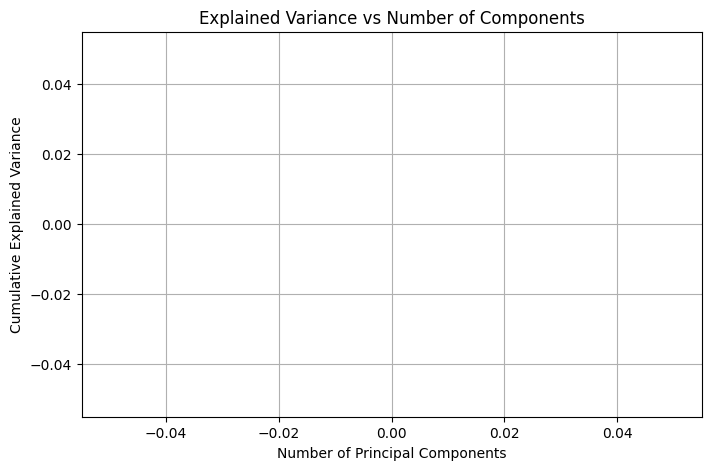

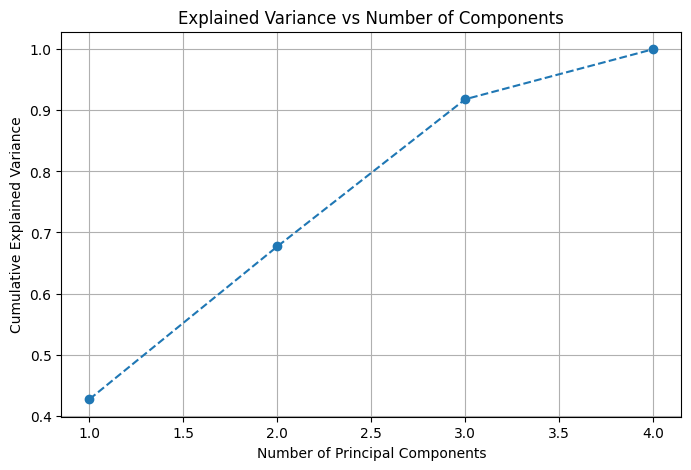

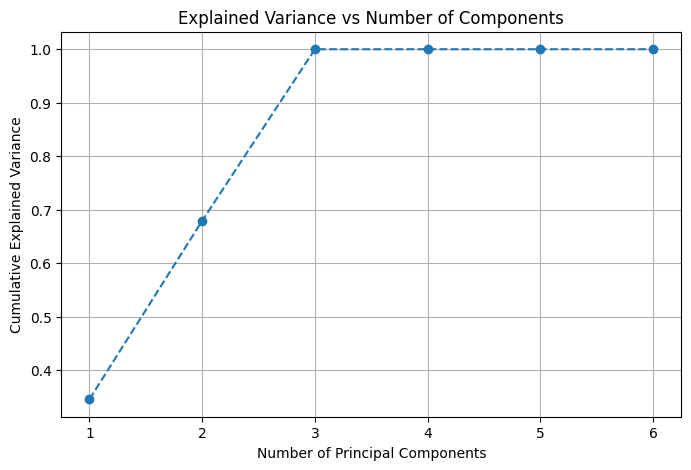

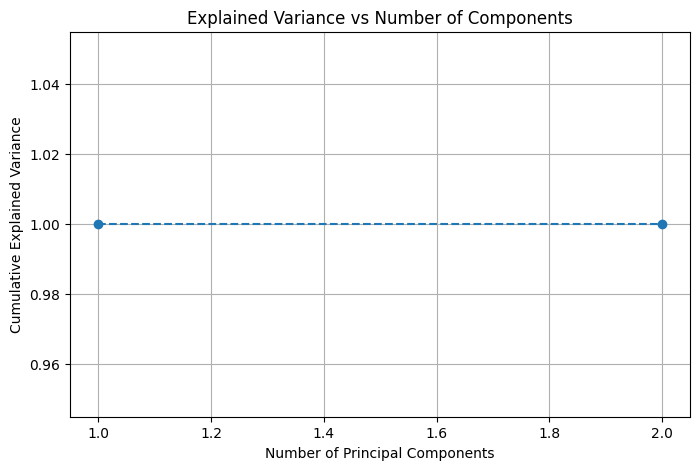

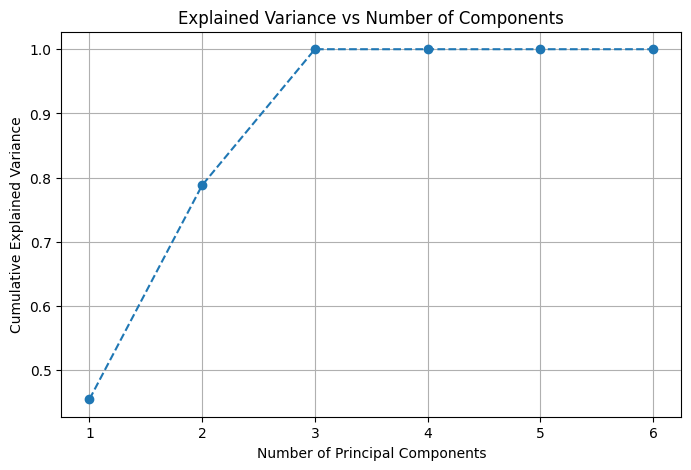

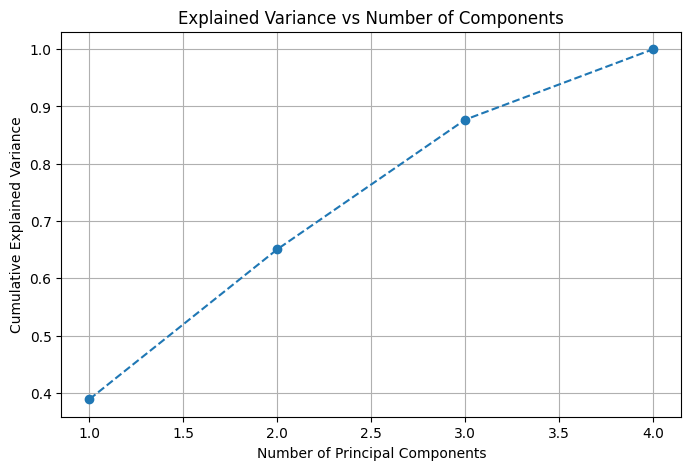

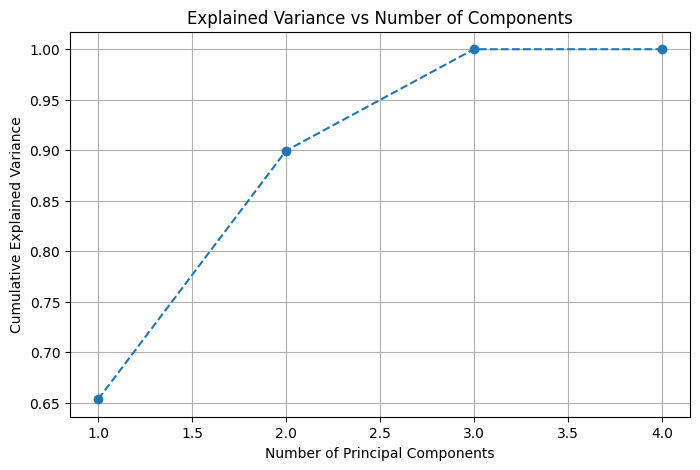

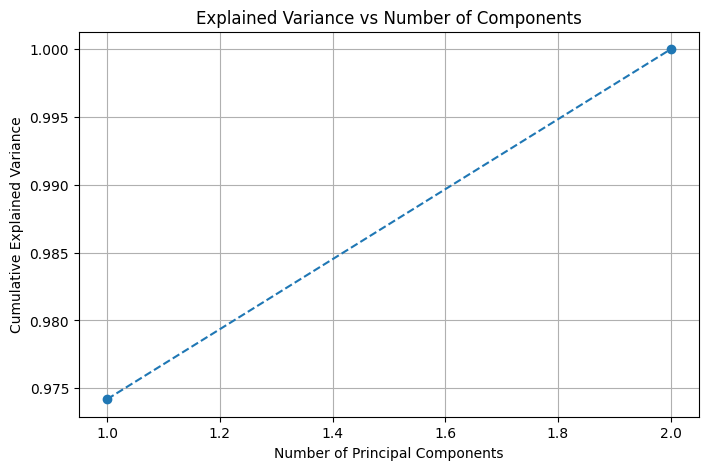

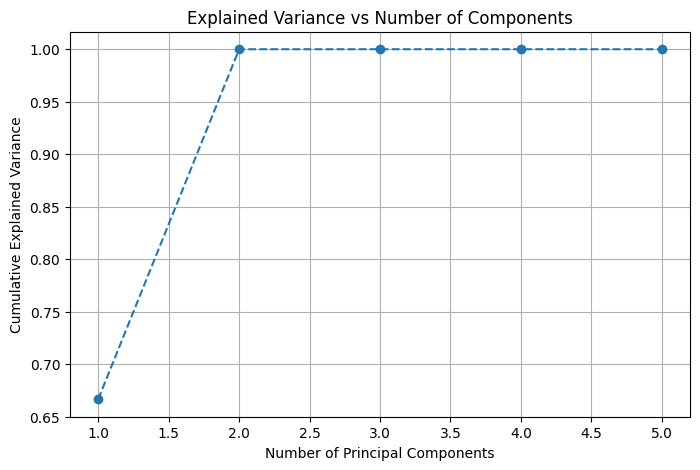

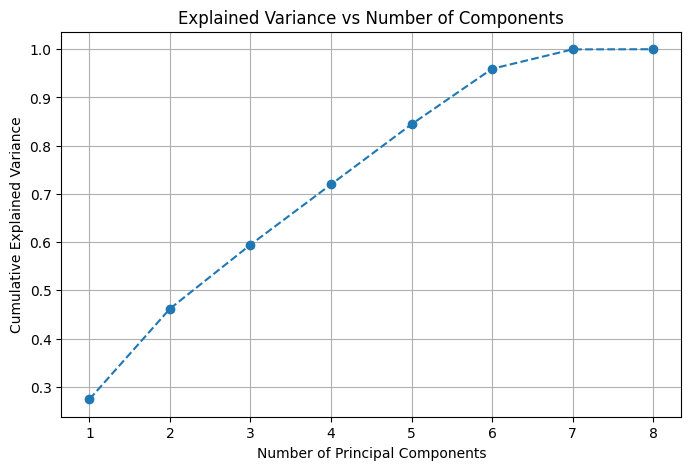

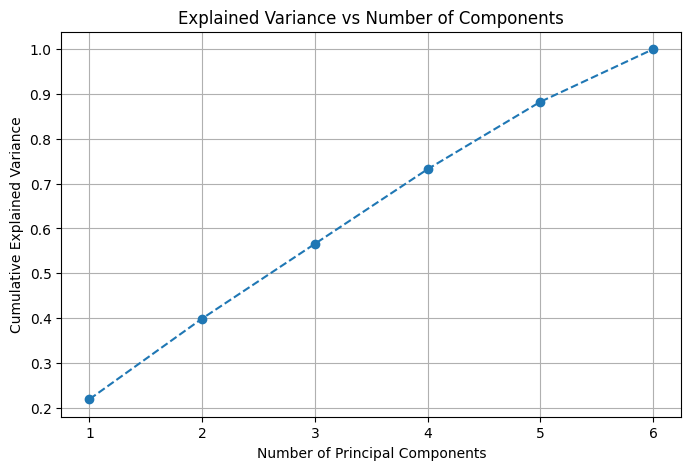

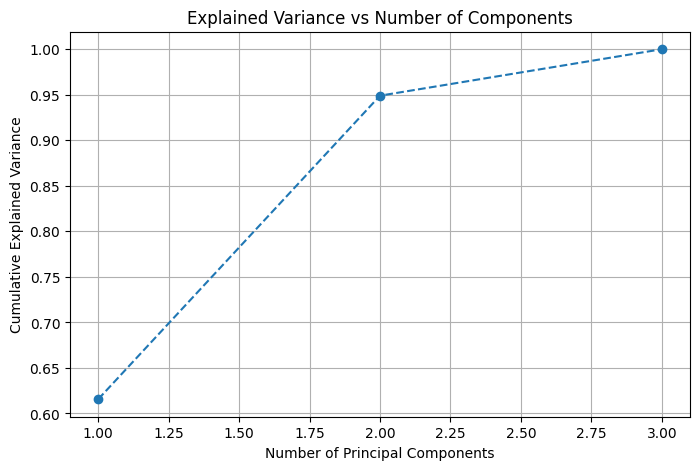

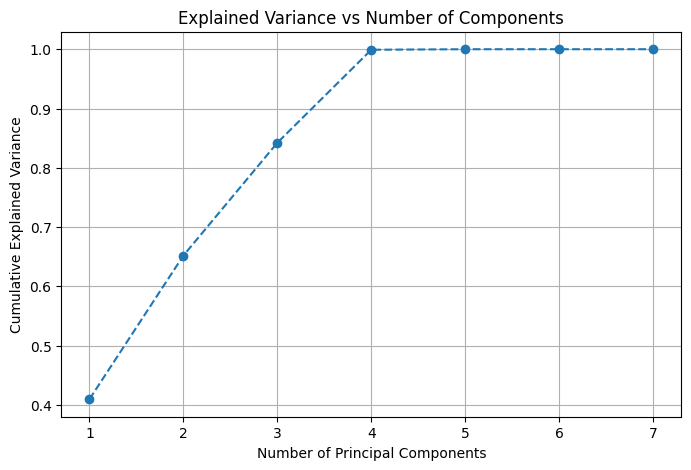

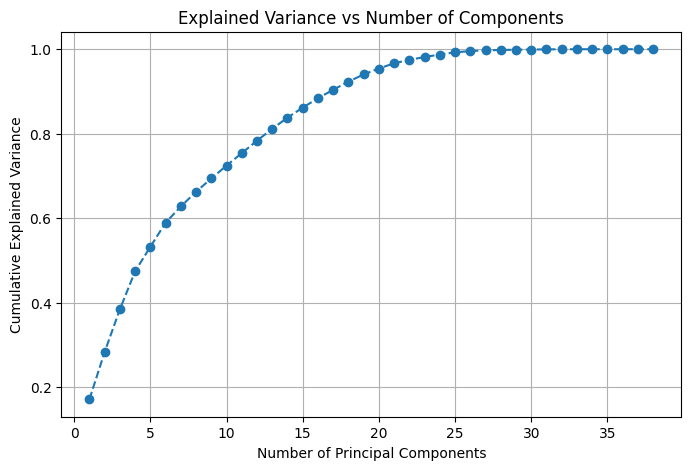

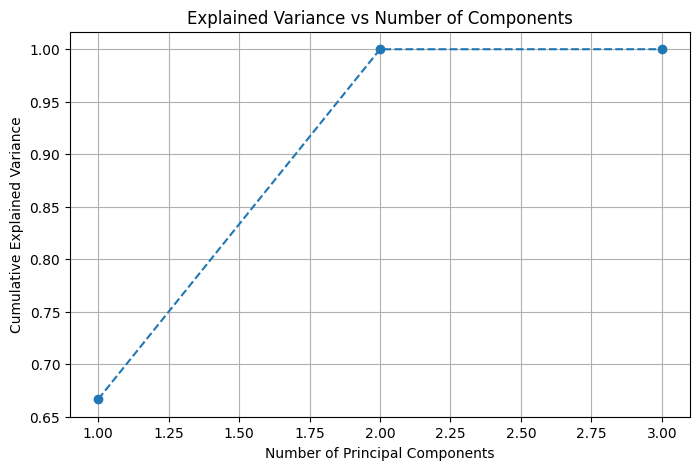

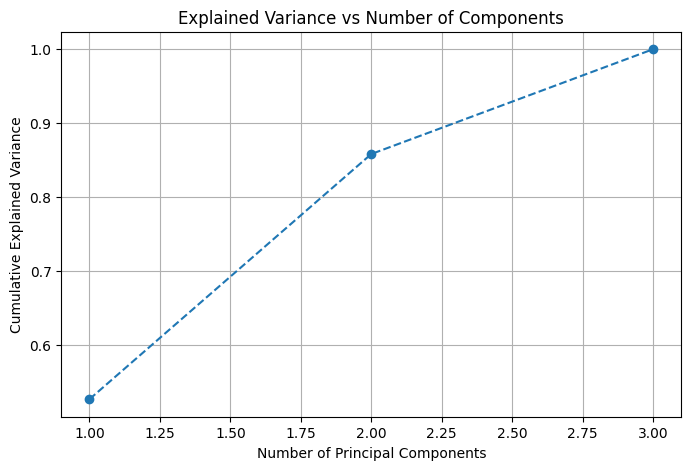

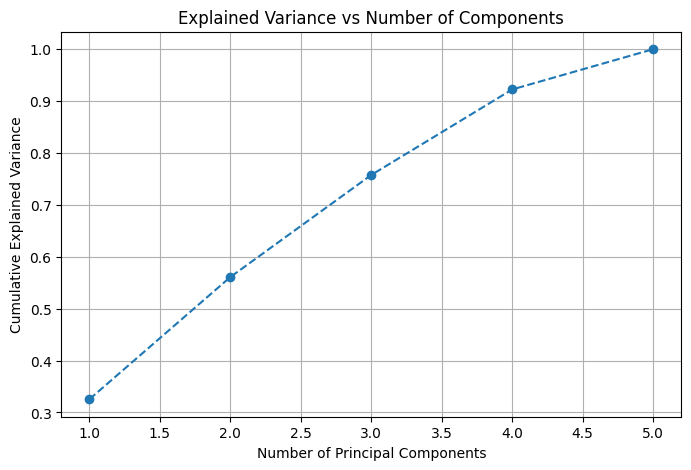

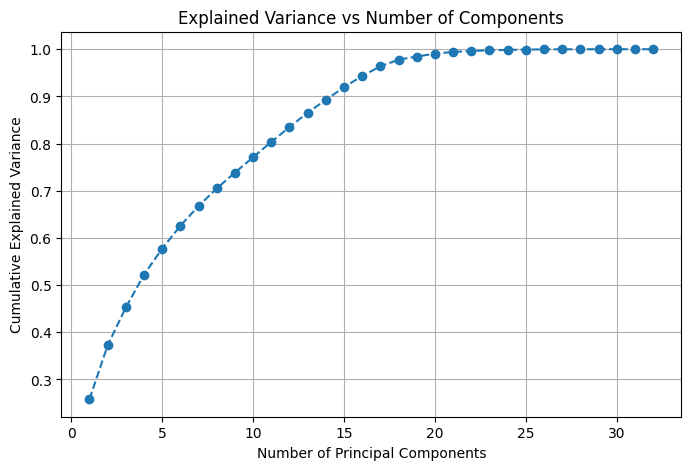

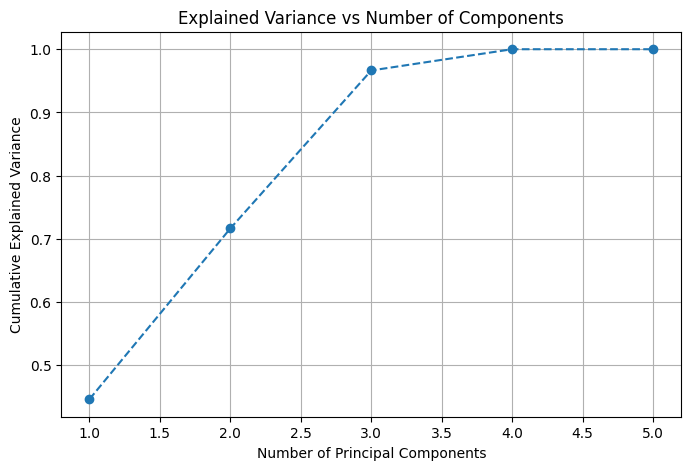

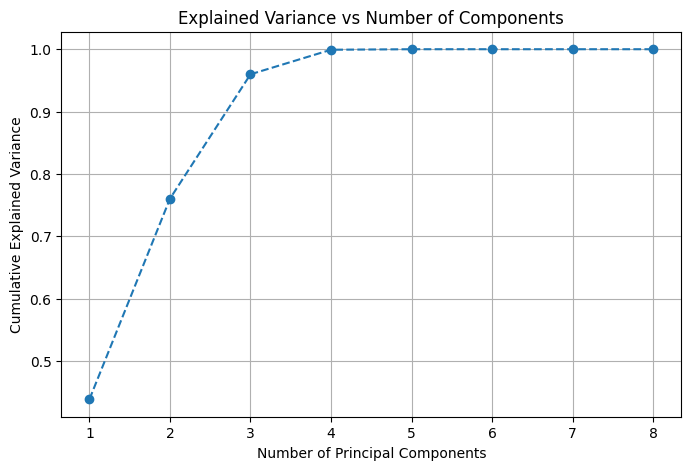

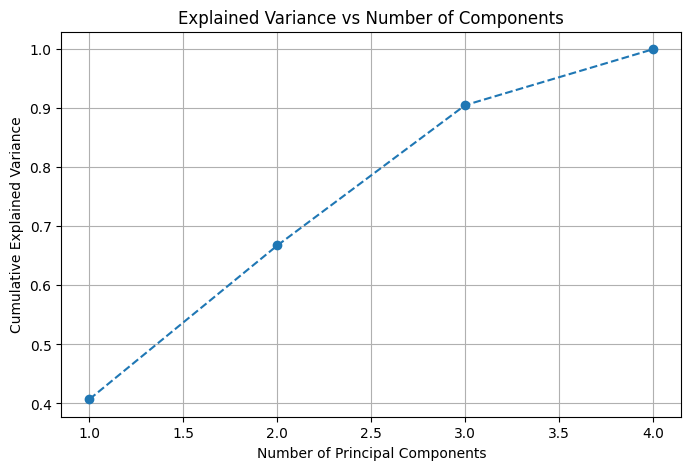

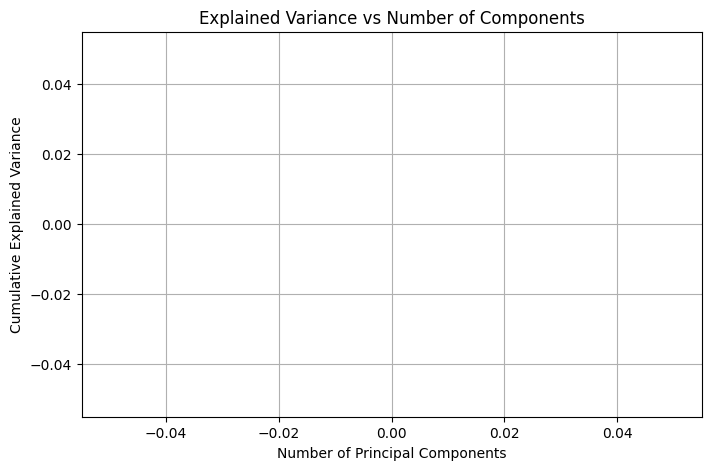

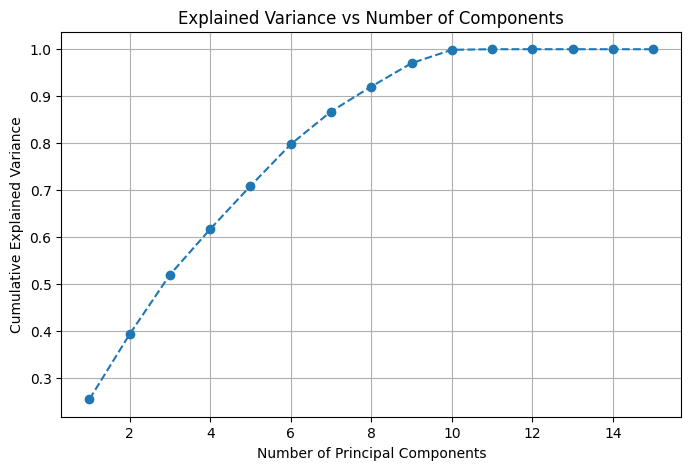

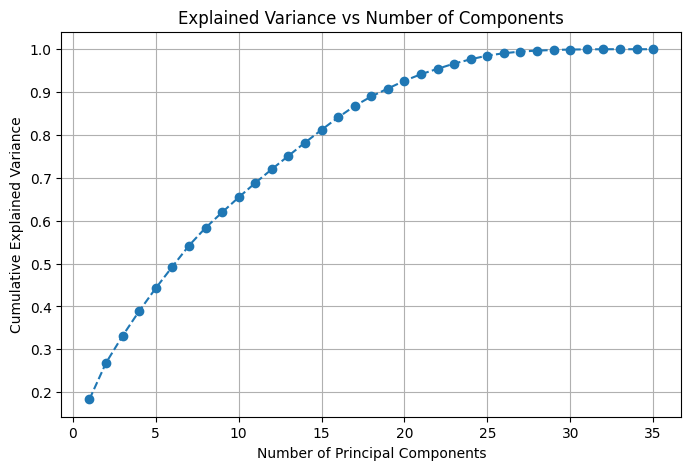

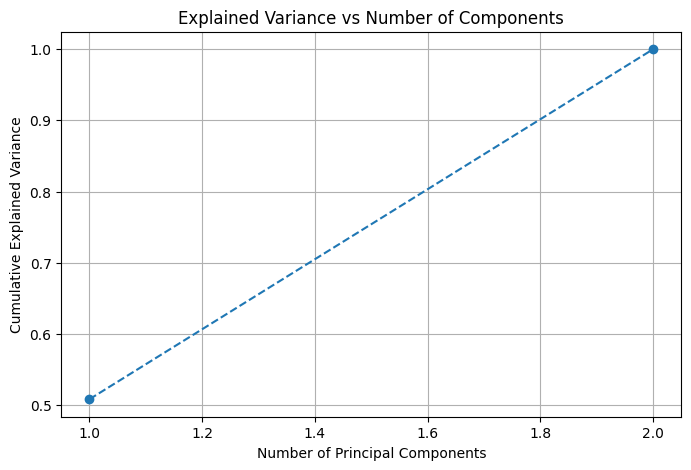

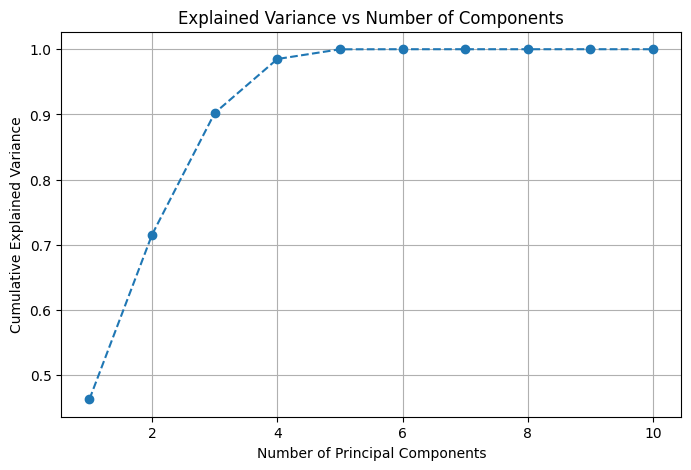

In [120]:
for analysis_file in os.listdir("output/analysis"):
    print(analysis_file)
    analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)
    analysis_df.to_csv(f"./output/analysis_imputed/{analysis_file}")
    pickle.dump(imp_mean, open(f"models/imputers/{analysis_file.replace('csv','pkl')}","wb"))
    # if(len(analysis_df) == 0):
    #     continue
    if(len(analysis_df.columns) == 1):
        continue
    sc = StandardScaler()
    pca = PCA()
    analysis_scaled = sc.fit_transform(analysis_df)
    pca.fit(analysis_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components')
    plt.grid(True)
    plt.savefig(f"./output/pca_plots/{analysis_file.replace('.csv','.png')}")
    n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f'Number of components explaining 95% variance: {n_components}')
    if n_components < 2:
        n_components = 2
    
    pca_chems = pca_explained_variance_df[0]
    pca = PCA(n_components=n_components)
    pca_reduced_df = pca.fit_transform(analysis_scaled)
    analysis_scaled = pd.DataFrame(analysis_scaled,index=analysis_df.index)
    analysis_scaled.to_csv(f"output/analysis_scaled/{analysis_file}")
    np.save(f"output/pca_df/{analysis_file.replace('.csv','')}", pca_reduced_df)
    pickle.dump(sc, open(f"models/scalers/{analysis_file.replace('csv','pkl')}","wb"))
    pickle.dump(pca, open(f"models/pca/{analysis_file.replace('csv','pkl')}","wb"))

In [126]:
for analysis_file in os.listdir("output/pca_df"):
    print(analysis_file)
    pca_reduced_df = pd.DataFrame(np.load(f"output/pca_df/{analysis_file}"))
    if "Colloidal" in analysis_file:
        print(pca_reduced_df)
    if len(pca_reduced_df.columns) <= 2:
        continue
    mu = np.mean(pca_reduced_df, axis=0)
    sigma = np.cov(pca_reduced_df.T)
    print(sigma)
    pca_reduced_df['mahalanobis_distance'] = [distance.mahalanobis(pca_reduced_df.iloc[i], mu, np.linalg.inv(sigma)) for i in range(len(pca_reduced_df)) ]

    pd.DataFrame(pca_reduced_df).to_csv(f"output/mahalanobis_distance/{analysis_file}")

Aerobic Mesophilic Count.npy
Alkalinity in Water.npy
[[ 1.46461802e+00 -1.59272501e-16  1.79884237e-16]
 [-1.59272501e-16  1.00446665e+00  7.86993536e-17]
 [ 1.79884237e-16  7.86993536e-17  5.43573549e-01]]
Aluminium analysis.npy
[[ 5.51366204e+00 -6.52896895e-16 -1.16286242e-16  1.87644407e-16
  -2.21008956e-16 -2.81102233e-17  1.46600295e-15  2.41793746e-16
   3.57335096e-16  1.92253314e-17 -9.43499871e-17 -3.52654366e-16
  -1.57439355e-16]
 [-6.52896895e-16  3.57644478e+00  4.62568550e-16 -9.31934562e-17
   2.77350953e-16 -8.37414580e-16  8.34175324e-17 -1.59885962e-16
  -2.10395558e-16 -1.22366908e-16 -7.96482874e-17  3.35426048e-17
  -1.12820111e-17]
 [-1.16286242e-16  4.62568550e-16  2.58511479e+00  1.54337750e-15
   6.29493128e-16 -2.27487855e-16 -3.23273792e-16  2.22739046e-16
  -9.74266127e-17  3.28237816e-16 -1.19694934e-16  8.36352793e-17
   1.60716830e-16]
 [ 1.87644407e-16 -9.31934562e-17  1.54337750e-15  2.32739419e+00
   2.35417546e-15 -1.94114675e-16  8.36886952e-17 -4.

In [127]:
analysis_file

'Yeasts & Molds.npy'

In [158]:
mahalanobis_threshold_dict = {}
for analysis_file in os.listdir("output/mahalanobis_distance"):
    print(analysis_file)
    analysis = analysis_file.replace(".csv","")
    mahalanobis_df = pd.read_csv(f"output/mahalanobis_distance/{analysis_file}",index_col=0)
    upper_quantile = (mahalanobis_df['mahalanobis_distance'].quantile(0.95))
    mahalanobis_threshold_dict[analysis_file.replace(".npy","")] = upper_quantile
    mahalanobis_df.loc[mahalanobis_df['mahalanobis_distance'] >= upper_quantile].to_csv(f"output/mahanobis_distance_upper_quantile/{analysis_file}")
    plt.boxplot(mahalanobis_df['mahalanobis_distance'])
    plt.savefig(f"output/mahalanobis_boxplots/{analysis}.png")
    plt.clf()
pickle.dump(mahalanobis_threshold_dict, open("mahalanobis_thresholds.dict","wb"))

Aerobic Mesophilic Count.npy
Alkalinity in Water.npy
Aluminium analysis.npy
Arsenic in Water.npy
Basic Drinking Water Analysis (WHO).npy
Basic Drinking Water Analysis.npy
Carbonates in Water.npy
Chemical & Biochemical Oxygen Demand.npy
Chemical Oxygen Demand.npy
Clostridium Perfringens.npy
E coli & Total Coliforms.npy
Feacal Coliforms (MPN) and E.Coli.npy
Fluoride in Water.npy
Free Chlorine.npy
Heavy Metal Analysis (Water).npy
Heavy Metals in Water.npy
Iron in Water.npy
Irrigation Water Analysis (FAO).npy
Irrigation Water Analysis.npy
KEBS Drinking Water Microbiology.npy
KEBS Drinking Water Standard Analysis.npy
Listeria Analysis.npy
Oil & Grease.npy
pH Analysis.npy
pH in Water.npy
Pseudomonas Aeruginosa.npy
Reverse Osmosis Water Use.npy
Standard Drinking Water Analysis (WHO).npy
Standard Drinking Water Analysis.npy
Staphylococcus aureus.npy
Streptococcus faecalis.npy
Strontium Analysis.npy
Total Bacteria Count.npy
Total Bacterial Count.npy
Total Chlorine.npy
Total Coliform and Faecal 

<Figure size 640x480 with 0 Axes>

In [159]:
(mahalanobis_threshold_dict.keys())

dict_keys(['Aerobic Mesophilic Count', 'Alkalinity in Water', 'Aluminium analysis', 'Arsenic in Water', 'Basic Drinking Water Analysis (WHO)', 'Basic Drinking Water Analysis', 'Carbonates in Water', 'Chemical & Biochemical Oxygen Demand', 'Chemical Oxygen Demand', 'Clostridium Perfringens', 'E coli & Total Coliforms', 'Feacal Coliforms (MPN) and E.Coli', 'Fluoride in Water', 'Free Chlorine', 'Heavy Metal Analysis (Water)', 'Heavy Metals in Water', 'Iron in Water', 'Irrigation Water Analysis (FAO)', 'Irrigation Water Analysis', 'KEBS Drinking Water Microbiology', 'KEBS Drinking Water Standard Analysis', 'Listeria Analysis', 'Oil & Grease', 'pH Analysis', 'pH in Water', 'Pseudomonas Aeruginosa', 'Reverse Osmosis Water Use', 'Standard Drinking Water Analysis (WHO)', 'Standard Drinking Water Analysis', 'Staphylococcus aureus', 'Streptococcus faecalis', 'Strontium Analysis', 'Total Bacteria Count', 'Total Bacterial Count', 'Total Chlorine', 'Total Coliform and Faecal E.Coli', 'Total Dissolv

In [130]:
new_samples_df.analysis_name.unique()

array(['Reverse Osmosis Water Use', 'Irrigation Water Analysis (FAO)',
       'Standard Drinking Water Analysis (WHO)',
       'KEBS Drinking Water Standard Analysis',
       'Post Harvest Water Analysis', 'KEBS Drinking Water Microbiology',
       'Heavy Metals in Water', 'Sulphur in Water',
       'E coli & Total Coliforms', 'Water Colour Analysis',
       'Total Silica in Water', 'Chemical Oxygen Demand',
       'Alkalinity in Water', 'Total Bacteria Count', 'Salmonella spp',
       'E coli', 'Water Borne Diseases', 'Staphylococcus aureus',
       'Listeria monocytogens', 'Raw (Domestic) Water Analysis',
       'Total Suspended Solids', 'pH in Water', 'Total coliforms',
       'KEBS Drinking Water Minimum Monitoring', 'Aluminium analysis',
       'Total Chlorine', 'Free Chlorine',
       'Basic Drinking Water Analysis (WHO)', 'Total Dissolved Solids',
       'Strontium Analysis', 'Pseudomonas Aeruginosa',
       'Streptococcus faecalis', 'Shigella spp', 'Fluoride in Water',
       '

In [131]:
conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [132]:
reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']
reverse_analysis_dict

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\3771434913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']


{'% Gypsum': 540,
 '% Nitrogen (RSSP 2)': 647,
 '% Organic Matter': 258,
 '% Organic Matter (RSSP 2)': 646,
 '% Soil Nitrogen': 18,
 '%Assay': 27235,
 '%N (RSSP 2)': 652,
 '%OM (RSSP 2)': 651,
 '%P,%S Analysis(Super Calcium)': 383,
 '1:2 Soil Volume Extract': 294,
 '1:2 soil volume extract': 25,
 '1:2 Soil Volume Extract (Data Only)': 27339,
 '1:2 Vol Extract for BLGG': 317,
 '20:12:12 (N,P205,K20) Analysis': 840,
 'Absorbance at 254nm': 26936,
 'Acid Detergent Fibre': 27063,
 'Acid Insoluble Ash': 27417,
 'Acid Insoluble Matter': 27108,
 'Acid titration': 26647,
 'Acid Value': 26971,
 'Advanced Biological Farming Soil Audit': 26521,
 'Advanced Soil Health Analysis': 27181,
 'Aerobic Mesophilic Count': 26649,
 'Aflatoxin': 26794,
 'Aflatoxin AFB1': 26938,
 'Aflatoxin B1': 26939,
 'Aflatoxin in feed': 767,
 'Aflatoxin M1': 27469,
 'Aflatoxin Total': 766,
 'AfSIS Standard Leaf Analysis': 633,
 'AFSIS Std Wet Chemistry Soil Analysis': 589,
 'Aggregate Stability': 26727,
 'Agrifi Soil Micr

In [133]:
len(reverse_analysis_dict.keys())

1337

In [134]:
len(new_samples_df[['sample_code','analysis_name']].value_counts())

2979

In [135]:
test = []

In [136]:
for sample in new_samples_df.sample_code.unique():
    res = {}
    tmp_ = new_samples_df.loc[new_samples_df.sample_code == sample]
    res['sample_code'] = sample
    res['analysis_id'] = [ reverse_analysis_dict[i] for i in tmp_.analysis_name.unique() if i in reverse_analysis_dict.keys() ]
    for index,row in tmp_.iterrows():
        if row['result'] >= 0 :
            res[row['chemical_name']] = {'result': row['result'], 'units': str(row['unit_name'])}
        else:
            res[row['chemical_name']] = {'result': 0, 'units': row['unit_name']}
    test.append(res)    


In [137]:
test

[{'sample_code': 'AGD517WA0013',
  'analysis_id': [324],
  'total_suspended_solids': {'result': 0.0, 'units': 'ppm'},
  'electrical_conductivity': {'result': 1.56, 'units': 'mS cm -1'}},
 {'sample_code': 'AGD517WA0014',
  'analysis_id': [324],
  'electrical_conductivity': {'result': 0.47, 'units': 'mS cm -1'},
  'total_suspended_solids': {'result': 0.0, 'units': 'ppm'}},
 {'sample_code': 'AGD517WA0016',
  'analysis_id': [27008],
  'bicarbonate': {'result': 1070.0, 'units': 'ppm'},
  'ammonium': {'result': 0.01, 'units': 'ppm'},
  'nitrates': {'result': 94.7, 'units': 'ppm'},
  'calcium': {'result': 113.0, 'units': 'ppm'},
  'manganese': {'result': 0.01, 'units': 'ppm'},
  'copper': {'result': 0.01, 'units': 'ppm'},
  'boron': {'result': 0.26, 'units': 'ppm'},
  'silicon__': {'result': 68.0, 'units': 'ppm'},
  'iron': {'result': 0.012, 'units': 'ppm'},
  'sulphur': {'result': 174.0, 'units': 'ppm'},
  'zinc': {'result': 0.01, 'units': 'ppm'},
  'nitrate_n': {'result': 21.4, 'units': 'pp

In [138]:
str(test).replace("'", '"')

'[{"sample_code": "AGD517WA0013", "analysis_id": [324], "total_suspended_solids": {"result": 0.0, "units": "ppm"}, "electrical_conductivity": {"result": 1.56, "units": "mS cm -1"}}, {"sample_code": "AGD517WA0014", "analysis_id": [324], "electrical_conductivity": {"result": 0.47, "units": "mS cm -1"}, "total_suspended_solids": {"result": 0.0, "units": "ppm"}}, {"sample_code": "AGD517WA0016", "analysis_id": [27008], "bicarbonate": {"result": 1070.0, "units": "ppm"}, "ammonium": {"result": 0.01, "units": "ppm"}, "nitrates": {"result": 94.7, "units": "ppm"}, "calcium": {"result": 113.0, "units": "ppm"}, "manganese": {"result": 0.01, "units": "ppm"}, "copper": {"result": 0.01, "units": "ppm"}, "boron": {"result": 0.26, "units": "ppm"}, "silicon__": {"result": 68.0, "units": "ppm"}, "iron": {"result": 0.012, "units": "ppm"}, "sulphur": {"result": 174.0, "units": "ppm"}, "zinc": {"result": 0.01, "units": "ppm"}, "nitrate_n": {"result": 21.4, "units": "ppm"}, "sulphate": {"result": 521.0, "uni

In [139]:
reverse_analysis_dict[ 'KEBS Drinking Water Microbiology']

26724

In [140]:
new_samples_df.analysis_name.unique()

array(['Reverse Osmosis Water Use', 'Irrigation Water Analysis (FAO)',
       'Standard Drinking Water Analysis (WHO)',
       'KEBS Drinking Water Standard Analysis',
       'Post Harvest Water Analysis', 'KEBS Drinking Water Microbiology',
       'Heavy Metals in Water', 'Sulphur in Water',
       'E coli & Total Coliforms', 'Water Colour Analysis',
       'Total Silica in Water', 'Chemical Oxygen Demand',
       'Alkalinity in Water', 'Total Bacteria Count', 'Salmonella spp',
       'E coli', 'Water Borne Diseases', 'Staphylococcus aureus',
       'Listeria monocytogens', 'Raw (Domestic) Water Analysis',
       'Total Suspended Solids', 'pH in Water', 'Total coliforms',
       'KEBS Drinking Water Minimum Monitoring', 'Aluminium analysis',
       'Total Chlorine', 'Free Chlorine',
       'Basic Drinking Water Analysis (WHO)', 'Total Dissolved Solids',
       'Strontium Analysis', 'Pseudomonas Aeruginosa',
       'Streptococcus faecalis', 'Shigella spp', 'Fluoride in Water',
       '

In [141]:
import psycopg2

conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [142]:
analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\3258811639.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


In [143]:
analysis_dict

{540: '% Gypsum',
 647: '% Nitrogen (RSSP 2)',
 258: '% Organic Matter',
 646: '% Organic Matter (RSSP 2)',
 18: '% Soil Nitrogen',
 27235: '%Assay',
 652: '%N (RSSP 2)',
 651: '%OM (RSSP 2)',
 383: '%P,%S Analysis(Super Calcium)',
 294: '1:2 Soil Volume Extract',
 25: '1:2 soil volume extract',
 27339: '1:2 Soil Volume Extract (Data Only)',
 317: '1:2 Vol Extract for BLGG',
 840: '20:12:12 (N,P205,K20) Analysis',
 26936: 'Absorbance at 254nm',
 27063: 'Acid Detergent Fibre',
 27146: 'Acid Insoluble Ash',
 27003: 'Acid Insoluble Ash',
 27417: 'Acid Insoluble Ash',
 27108: 'Acid Insoluble Matter',
 26647: 'Acid titration',
 26971: 'Acid Value',
 26521: 'Advanced Biological Farming Soil Audit',
 27181: 'Advanced Soil Health Analysis',
 26649: 'Aerobic Mesophilic Count',
 26794: 'Aflatoxin',
 26938: 'Aflatoxin AFB1',
 26939: 'Aflatoxin B1',
 767: 'Aflatoxin in feed',
 27469: 'Aflatoxin M1',
 26753: 'Aflatoxin Total',
 766: 'Aflatoxin Total',
 633: 'AfSIS Standard Leaf Analysis',
 589: 'AF

In [144]:
pickle.dump(analysis_dict, open("analysis.dict","wb"))

In [145]:
analysis_dict = pickle.load(open("analysis.dict","rb"))

In [146]:
analysis_dict

{540: '% Gypsum',
 647: '% Nitrogen (RSSP 2)',
 258: '% Organic Matter',
 646: '% Organic Matter (RSSP 2)',
 18: '% Soil Nitrogen',
 27235: '%Assay',
 652: '%N (RSSP 2)',
 651: '%OM (RSSP 2)',
 383: '%P,%S Analysis(Super Calcium)',
 294: '1:2 Soil Volume Extract',
 25: '1:2 soil volume extract',
 27339: '1:2 Soil Volume Extract (Data Only)',
 317: '1:2 Vol Extract for BLGG',
 840: '20:12:12 (N,P205,K20) Analysis',
 26936: 'Absorbance at 254nm',
 27063: 'Acid Detergent Fibre',
 27146: 'Acid Insoluble Ash',
 27003: 'Acid Insoluble Ash',
 27417: 'Acid Insoluble Ash',
 27108: 'Acid Insoluble Matter',
 26647: 'Acid titration',
 26971: 'Acid Value',
 26521: 'Advanced Biological Farming Soil Audit',
 27181: 'Advanced Soil Health Analysis',
 26649: 'Aerobic Mesophilic Count',
 26794: 'Aflatoxin',
 26938: 'Aflatoxin AFB1',
 26939: 'Aflatoxin B1',
 767: 'Aflatoxin in feed',
 27469: 'Aflatoxin M1',
 26753: 'Aflatoxin Total',
 766: 'Aflatoxin Total',
 633: 'AfSIS Standard Leaf Analysis',
 589: 'AF

In [147]:
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

In [148]:
pd.DataFrame({'analysis_name':mahalanobis_thresholds.keys()}).to_csv("output/analyses_in_models.csv")

In [149]:
unit_decision = pd.read_csv("output/water_unit_per_chemical_decision.csv")

In [150]:
unit_decision

Unnamed: 0                       analysis_name           chemical_name  \
0             0           Irrigation Water Analysis           faecal_e_coli   
1             0           Irrigation Water Analysis           feacal_e_coli   
2             0           Irrigation Water Analysis  total_suspended_solids   
3             0           Irrigation Water Analysis          salmonella_ssp   
4             0           Irrigation Water Analysis         total_coliforms   
..          ...                                 ...                     ...   
595           0      KS Packaged Water Microbiology   staphylococcus_aureus   
596           0      KS Packaged Water Microbiology                shigella   
597           0       Salmonella and E.Coli (Water)                  e_coli   
598           0                             TVC @22       tvc_at_30_degrees   
599           0   Feacal Coliforms (MPN) and E.Coli           feacal_e_coli   

      unit_name  
0     cfu/100ml  
1    cfu/100 ml  
2           ppm  
3      in 100ml  
4     mpn/100ml  
..          ...  
595  cfu/100 ml  
596  cfu/100 ml  
597  cfu/100 ml  
598      cfu/ml  
599  cfu/100 ml  

[600 rows x 4 columns]

In [169]:
unit_decision.loc[unit_decision['analysis_name'] == 'Total Silica in Water']

Unnamed: 0          analysis_name            chemical_name  unit_name
515           0  Total Silica in Water          total_coliforms  mpn/100ml
516           0  Total Silica in Water  electrical_conductivity   mS cm -1
517           0  Total Silica in Water                   e_coli  mpn/100ml
518           0  Total Silica in Water                   e_coli  mpn/100ml

In [170]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/water_unit_per_chemical_decision.csv")
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

result = {}
_df = _.explode('analysis_id', ignore_index=True)
import math
for index,row in _df.iterrows():
    sample_code = row['sample_code']
    if sample_code not in result.keys():
        result[sample_code] = []
    if math.isnan(row['analysis_id']):
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in specified", "details": f"Analysis id not provided" })   
        continue
    row['analysis_name'] = analysis_dict[row['analysis_id']]
    analysis = row['analysis_name']
    analysis_id = row['analysis_id']
    if analysis not in mahalanobis_thresholds.keys():
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in models", "details": f"Analysis: {analysis} is not in the list of defined models" })   
        continue  
    row = row.dropna()
    scaler = pickle.load(open(f"models/scalers/{analysis}.pkl","rb"))
    pca = pickle.load(open(f"models/pca/{analysis}.pkl","rb"))
    imputer = pickle.load(open(f"models/imputers/{analysis}.pkl","rb"))
    analysis_df = pd.read_csv(f"output/analysis/{analysis}.csv",index_col=0)

    

    try :
        tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    except Exception as e:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Missing parameters for analysis: {analysis}", "details": f"Expected parameters are {','.join(analysis_df.columns)} for analysis: {analysis}" })
        continue
    failed_units_comparison = {}    
    for col in tmp_df.columns:
        print("Column", col)
        print("Column", analysis)
        print(expected_units)
        expected_units = unit_decision.loc[(unit_decision['analysis_name'] == analysis) & (unit_decision['chemical_name'] == col)]
        
        import math
        if type(row[col]) != dict and math.isnan(row[col]):
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = None
            print(col)
            print(failed_units_comparison)
        elif row[col]['units'] !=   expected_units['unit_name'].values[0] :
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = row[col]['units']
        else:
            continue    
    if len(failed_units_comparison.keys()) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Wrong units provided", "details": f"Expected units are {str(failed_units_comparison)} for analysis: {analysis}" })
        continue
    for col in analysis_df.columns:
        if type(row[col]) == dict:
            row[col] = row[col]['result']
    
    out_of_bounds_chems = [ ]
    for col in tmp_df.columns:
        if col == "sample_code":
            continue
        if col == "ec_salts":
            if row[col] > 105 or row[col] < 95:
                out_of_bounds_chems.append("ec_salts out of bounds. Allowed bounds are 95 - 105")
        if col == "Charge Balance":
            if row[col] < -1:
                out_of_bounds_chems.append("Charge Balance out of bounds. Allowed lower boundary is -10. ")       
        elif col.lower() == "total suspended solids" and row['analysis_name'].lower() == "total suspended solids":
            if row[col] > 1:
                out_of_bounds_chems.append("total suspended solids out of bounds. If analysis is total suspended solids is <1 then total suspended solids check should be <1  . ")         
    if len(out_of_bounds_chems) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Out of bounds", "details": f"{'.'.join(out_of_bounds_chems)}" })
        continue    

    tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    tmp_df = imputer.transform(tmp_df)
    df_scaled = scaler.transform(tmp_df)
    df_pca = pd.DataFrame(pca.transform(df_scaled))

    mu = np.mean(df_pca, axis=0)
    sigma = np.cov(df_pca.T)

    mahalanobis_distance = distance.mahalanobis(df_pca.iloc[0], mu, np.linalg.inv(sigma))


    expected_md = mahalanobis_thresholds[analysis]

    if mahalanobis_distance > expected_md:
        result[sample_code].append({"sample_code": sample_code,"status":"fail", "message": "Mahalanobis distance exceeds threshold", "details":f"Mahalanobis distance of {mahalanobis_distance} exceeds threshold of {expected_md} for analysis: {analysis}" })
    else:
        result[sample_code].append({"sample_code": sample_code,"status":"pass","message": "Mahalanobis distance within threshold", "details":f"Mahalanobis distance of {mahalanobis_distance} is within threshold of {expected_md} for analysis: {analysis}" })
          

Column e_coli
Column Total Silica in Water
Empty DataFrame
Columns: [Unnamed: 0, crop, chemical_name, unit_name]
Index: []
Column electrical_conductivity
Column Total Silica in Water
     Unnamed: 0          analysis_name chemical_name  unit_name
517           0  Total Silica in Water        e_coli  mpn/100ml
518           0  Total Silica in Water        e_coli  mpn/100ml
Column total_coliforms
Column Total Silica in Water
     Unnamed: 0          analysis_name            chemical_name unit_name
516           0  Total Silica in Water  electrical_conductivity  mS cm -1
Column e_coli
Column Total Silica in Water
     Unnamed: 0          analysis_name    chemical_name  unit_name
515           0  Total Silica in Water  total_coliforms  mpn/100ml
Column electrical_conductivity
Column Total Silica in Water
     Unnamed: 0          analysis_name chemical_name  unit_name
517           0  Total Silica in Water        e_coli  mpn/100ml
518           0  Total Silica in Water        e_coli  mpn/10

C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\83545998.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma = np.cov(df_pca.T)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31

Column aluminium
Column Aluminium analysis
     Unnamed: 0          analysis_name    chemical_name  unit_name
515           0  Total Silica in Water  total_coliforms  mpn/100ml
Column ammonium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
422           0  Aluminium analysis     aluminium       ppm
Column bicarbonate
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
421           0  Aluminium analysis      ammonium       ppm
Column boron
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
420           0  Aluminium analysis   bicarbonate       ppm
Column calcium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
419           0  Aluminium analysis         boron       ppm
Column chloride
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
418           0  Aluminium analysis       calcium       ppm
Column copper


C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\83545998.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma = np.cov(df_pca.T)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31

Column aluminium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
401           0  Aluminium analysis          zinc       ppm
Column ammonium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
422           0  Aluminium analysis     aluminium       ppm
Column bicarbonate
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
421           0  Aluminium analysis      ammonium       ppm
Column boron
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
420           0  Aluminium analysis   bicarbonate       ppm
Column calcium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
419           0  Aluminium analysis         boron       ppm
Column chloride
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
418           0  Aluminium analysis       calcium       ppm
Column copper
Column Alumini

C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\83545998.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma = np.cov(df_pca.T)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31

Column aluminium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
401           0  Aluminium analysis          zinc       ppm
Column ammonium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
422           0  Aluminium analysis     aluminium       ppm
Column bicarbonate
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
421           0  Aluminium analysis      ammonium       ppm
Column boron
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
420           0  Aluminium analysis   bicarbonate       ppm
Column calcium
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
419           0  Aluminium analysis         boron       ppm
Column chloride
Column Aluminium analysis
     Unnamed: 0       analysis_name chemical_name unit_name
418           0  Aluminium analysis       calcium       ppm
Column copper
Column Alumini

C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\83545998.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma = np.cov(df_pca.T)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31

Column e_coli
Column Total Silica in Water
     Unnamed: 0       analysis_name chemical_name unit_name
401           0  Aluminium analysis          zinc       ppm
Column electrical_conductivity
Column Total Silica in Water
     Unnamed: 0          analysis_name chemical_name  unit_name
517           0  Total Silica in Water        e_coli  mpn/100ml
518           0  Total Silica in Water        e_coli  mpn/100ml
Column total_coliforms
Column Total Silica in Water
     Unnamed: 0          analysis_name            chemical_name unit_name
516           0  Total Silica in Water  electrical_conductivity  mS cm -1


C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_31536\83545998.py:86: RuntimeWarning: Degrees of freedom <= 0 for slice
  sigma = np.cov(df_pca.T)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [157]:

mahalanobis_thresholds

{'Aerobic Mesophilic Count.npy': np.float64(1.7888543819998317),
 'Alkalinity in Water.npy': np.float64(1.806473062017859),
 'Aluminium analysis.npy': np.float64(8.981725114059621),
 'Arsenic in Water.npy': np.float64(3.1359788144297442),
 'Basic Drinking Water Analysis (WHO).npy': np.float64(4.085511921737524),
 'Basic Drinking Water Analysis.npy': np.float64(2.5174219867065446),
 'Carbonates in Water.npy': np.float64(6.4575947952253046),
 'Chemical & Biochemical Oxygen Demand.npy': np.float64(8.627717238923006),
 'Chemical Oxygen Demand.npy': np.float64(3.00386120773966),
 'Clostridium Perfringens.npy': np.float64(5.224066502960976),
 'E coli & Total Coliforms.npy': np.float64(3.592583702403325),
 'Feacal Coliforms (MPN) and E.Coli.npy': np.float64(7.068909385199897),
 'Fluoride in Water.npy': np.float64(8.407867346094665),
 'Free Chlorine.npy': np.float64(5.0646215386641655),
 'Heavy Metal Analysis (Water).npy': np.float64(2.3626036118848424),
 'Heavy Metals in Water.npy': np.float6

In [171]:
len(test)

2257

In [172]:
result

{'AGD517WA0013': [{'sample_code': 'AGD517WA0013',
   'status': 'warning',
   'message': 'Missing parameters for analysis: Reverse Osmosis Water Use',
   'details': 'Expected parameters are arsenic,colour,electrical_conductivity,faecal_coliforms,faecal_e_coli,feacal_coliforms,feacal_coliforms_mpn,feacal_e_coli,pseudomonas_aeruginosa,salmonella,salmonella_ssp,shigella,staphylococcus_aureus,streptococcus_faecalis,tbc_at_22_degrees,tbc_at_37_degrees,total_coliforms,total_suspended_solids,vibrio_cholerae for analysis: Reverse Osmosis Water Use'}],
 'AGD517WA0014': [{'sample_code': 'AGD517WA0014',
   'status': 'warning',
   'message': 'Missing parameters for analysis: Reverse Osmosis Water Use',
   'details': 'Expected parameters are arsenic,colour,electrical_conductivity,faecal_coliforms,faecal_e_coli,feacal_coliforms,feacal_coliforms_mpn,feacal_e_coli,pseudomonas_aeruginosa,salmonella,salmonella_ssp,shigella,staphylococcus_aureus,streptococcus_faecalis,tbc_at_22_degrees,tbc_at_37_degrees,t

In [156]:
test

[{'sample_code': 'AGD517WA0013',
  'analysis_id': [324],
  'total_suspended_solids': {'result': 0.0, 'units': 'ppm'},
  'electrical_conductivity': {'result': 1.56, 'units': 'mS cm -1'}},
 {'sample_code': 'AGD517WA0014',
  'analysis_id': [324],
  'electrical_conductivity': {'result': 0.47, 'units': 'mS cm -1'},
  'total_suspended_solids': {'result': 0.0, 'units': 'ppm'}},
 {'sample_code': 'AGD517WA0016',
  'analysis_id': [27008],
  'bicarbonate': {'result': 1070.0, 'units': 'ppm'},
  'ammonium': {'result': 0.01, 'units': 'ppm'},
  'nitrates': {'result': 94.7, 'units': 'ppm'},
  'calcium': {'result': 113.0, 'units': 'ppm'},
  'manganese': {'result': 0.01, 'units': 'ppm'},
  'copper': {'result': 0.01, 'units': 'ppm'},
  'boron': {'result': 0.26, 'units': 'ppm'},
  'silicon__': {'result': 68.0, 'units': 'ppm'},
  'iron': {'result': 0.012, 'units': 'ppm'},
  'sulphur': {'result': 174.0, 'units': 'ppm'},
  'zinc': {'result': 0.01, 'units': 'ppm'},
  'nitrate_n': {'result': 21.4, 'units': 'pp

In [24]:
unit_decision.loc[unit_decision['crop'] == "Standard Drinking Water Analysis (WHO)"]

Unnamed: 0                                    crop  \
404           0  Standard Drinking Water Analysis (WHO)   
405           0  Standard Drinking Water Analysis (WHO)   
406           0  Standard Drinking Water Analysis (WHO)   
407           0  Standard Drinking Water Analysis (WHO)   
408           0  Standard Drinking Water Analysis (WHO)   
409           0  Standard Drinking Water Analysis (WHO)   
410           0  Standard Drinking Water Analysis (WHO)   
411           0  Standard Drinking Water Analysis (WHO)   
412           0  Standard Drinking Water Analysis (WHO)   
413           0  Standard Drinking Water Analysis (WHO)   
414           0  Standard Drinking Water Analysis (WHO)   
415           0  Standard Drinking Water Analysis (WHO)   
416           0  Standard Drinking Water Analysis (WHO)   
417           0  Standard Drinking Water Analysis (WHO)   
418           0  Standard Drinking Water Analysis (WHO)   
419           0  Standard Drinking Water Analysis (WHO)   
420           0  Standard Drinking Water Analysis (WHO)   
421           0  Standard Drinking Water Analysis (WHO)   
422           0  Standard Drinking Water Analysis (WHO)   
423           0  Standard Drinking Water Analysis (WHO)   
424           0  Standard Drinking Water Analysis (WHO)   
425           0  Standard Drinking Water Analysis (WHO)   
426           0  Standard Drinking Water Analysis (WHO)   
427           0  Standard Drinking Water Analysis (WHO)   
428           0  Standard Drinking Water Analysis (WHO)   
429           0  Standard Drinking Water Analysis (WHO)   
430           0  Standard Drinking Water Analysis (WHO)   
431           0  Standard Drinking Water Analysis (WHO)   
432           0  Standard Drinking Water Analysis (WHO)   
433           0  Standard Drinking Water Analysis (WHO)   

               chemical_name   unit_name  
404          total_coliforms   mpn/100ml  
405                   e_coli   mpn/100ml  
406            faecal_e_coli  cfu/100 ml  
407  electrical_conductivity    mS cm -1  
408                 hardness         ppm  
409              bicarbonate         ppm  
410                 sulphate         ppm  
411                 nitrates         ppm  
412               molybdenum         ppm  
413                manganese         ppm  
414                     iron         ppm  
415                nitrate_n         ppm  
416               phosphorus         ppm  
417                magnesium         ppm  
418                potassium         ppm  
419                 chloride         ppm  
420                   copper         ppm  
421                     zinc         ppm  
422                   sodium         ppm  
423                  sulphur         ppm  
424                  calcium         ppm  
425                 ammonium         ppm  
426                    boron         ppm  
427                silicon__         ppm  
428                   silica         ppm  
429                   e_coli   mpn/100ml  
430            faecal_e_coli  cfu/100 ml  
431                magnesium         ppm  
432                  calcium         ppm  
433          total_coliforms   mpn/100ml

In [173]:
final_df = pd.DataFrame()
for i in result.keys():
    out_df = (pd.DataFrame(result[i]))
    final_df = pd.concat([final_df, out_df])


In [174]:
final_df.to_csv("test_results.csv")

In [175]:
final_df

sample_code   status                                            message  \
0   AGD517WA0013  warning  Missing parameters for analysis: Reverse Osmos...   
0   AGD517WA0014  warning  Missing parameters for analysis: Reverse Osmos...   
0   AGD517WA0016  warning  Missing parameters for analysis: Irrigation Wa...   
0   AGD824WA0006  warning  Missing parameters for analysis: Irrigation Wa...   
0   AGD912WA0023  warning  Missing parameters for analysis: Irrigation Wa...   
..           ...      ...                                                ...   
0    FA948WA0005  warning  Missing parameters for analysis: Irrigation Wa...   
0    FA948WA0006  warning  Missing parameters for analysis: Reverse Osmos...   
0    FA948WA0009  warning  Missing parameters for analysis: Reverse Osmos...   
0    FA948WA0010  warning  Missing parameters for analysis: Reverse Osmos...   
0    FA951WA0001  warning  Missing parameters for analysis: Standard Drin...   

                                              details  
0   Expected parameters are arsenic,colour,electri...  
0   Expected parameters are arsenic,colour,electri...  
0   Expected parameters are aluminium,ammonium,bic...  
0   Expected parameters are aluminium,ammonium,bic...  
0   Expected parameters are aluminium,ammonium,bic...  
..                                                ...  
0   Expected parameters are aluminium,ammonium,bic...  
0   Expected parameters are arsenic,colour,electri...  
0   Expected parameters are arsenic,colour,electri...  
0   Expected parameters are arsenic,colour,electri...  
0   Expected parameters are e_coli,electrical_cond...  

[2979 rows x 4 columns]

In [225]:
pd.DataFrame([ result[i][0]  for i in result.keys()]).to_csv("test_results.csv")